In [ ]:
#| default_exp tycho2_main

importing dependencies

In [ ]:
#| export
import polars as pl
import numpy as np
import torch
import math
import time
import heapq
from typing import List, Any
import tqdm
import pickle
import pyarrow as pa
from dataclasses import dataclass, field

read the simplified tycho2 catalog

In [ ]:
df = pl.read_parquet('../support/tyc2-3.parquet')
print(df.describe())

shape: (9, 4)
┌────────────┬────────────┬────────────┬────────────┐
│ describe   ┆ RAmdeg     ┆ DEmdeg     ┆ Vmag       │
│ ---        ┆ ---        ┆ ---        ┆ ---        │
│ str        ┆ f64        ┆ f64        ┆ f64        │
╞════════════╪════════════╪════════════╪════════════╡
│ count      ┆ 2.430468e6 ┆ 2.430468e6 ┆ 2.430468e6 │
│ null_count ┆ 0.0        ┆ 0.0        ┆ 0.0        │
│ mean       ┆ 188.530502 ┆ -3.479685  ┆ 11.071772  │
│ std        ┆ 100.340485 ┆ 41.43108   ┆ 1.108483   │
│ min        ┆ 0.000339   ┆ -89.889664 ┆ 1.89558    │
│ 25%        ┆ 105.471535 ┆ -39.00515  ┆ 10.54628   │
│ 50%        ┆ 186.052124 ┆ -4.889748  ┆ 11.292219  │
│ 75%        ┆ 280.987732 ┆ 31.3225    ┆ 11.82646   │
│ max        ┆ 359.999878 ┆ 89.832336  ┆ 15.37354   │
└────────────┴────────────┴────────────┴────────────┘


In [ ]:
#| export

@dataclass(order=True)
class ScoreItem:
    score: float
    region: int=field(compare=False)
    item: Any=field(compare=False)
    
@dataclass(order=True)
class Points:
    points: Any=field(compare=False)
    

def convert_to_cartesian(distances, ra, dec):
    x = distances * torch.cos(dec) * torch.cos(ra)
    y = distances * torch.cos(dec) * torch.sin(ra)
    z = distances * torch.sin(dec)
    return torch.stack((x, y, z), dim=1)

def calculate_distances(coords):
    dist_matrix = torch.cdist(coords, coords)
    unique_distances = torch.unique(dist_matrix)
    return unique_distances[unique_distances > 0]

def distance_from_magnitude(m, M):
    return 10**((m - M + 5) / 5)

def distance_from_magnitude_tensor(m: torch.Tensor, M: torch.Tensor) -> torch.Tensor:
    return 10**((m - M + 5) / 5)

# one of the possibilities
def tetrahedron_score(coords):
    distances = calculate_distances(coords)
    print(distances)
    mean_distance = torch.mean(distances)
    std_dev = torch.std(distances)

    # Assuming std_dev is small enough, the score will be close to 1
    # Otherwise, it will be closer to 0
    score = math.exp(-std_dev.item() / mean_distance.item())
    return score

def square_score(tensor):
    """Return a measure of how close the points in a tensor are to forming a square,
    as well as the standard deviation of their brightness."""
    
    # Calculate pairwise distances based on the x and y coordinates (first two dimensions)
    spatial_distances = torch.pdist(tensor, p=2)
    print(spatial_distances)
    
    # Sort the distances
    sorted_distances = torch.sort(spatial_distances)[0]
    
    # Take the 4 smallest distances and compute their standard deviation
    std_of_smallest_4 = sorted_distances[:4].std().item()
    
    # # Calculate the standard deviation of the brightness (third dimension)
    # brightness_std = tensor[:, 2].std().item()
    
    return std_of_smallest_4

def measure_squareness_old(tensor):
    """
    :param points: A tensor of shape (4, 2) representing the 4 2D points
    :return: A float indicating the squareness. Closer to 1 means more square.
    """
    
    # Calculate pairwise distances based on the x and y coordinates (first two dimensions)
    spatial_distances = torch.pdist(tensor, p=2)

    # Sort the distances
    distances = torch.sort(spatial_distances)[0]
    
    # Mean of sides and diagonals
    mean_sides = torch.mean(distances[:4])
    mean_diagonal = torch.mean(distances[4:])
    
    # Squareness measure
    squareness = mean_diagonal / mean_sides
    
    # Normalize with sqrt(2) to get values closer to 1 for squares
    return abs(1 - (squareness / torch.sqrt(torch.tensor(2.0)).item()))

def measure_squareness(tensor):
    # Calculate pairwise distances based on the x and y coordinates (first two dimensions)
    spatial_distances = torch.pdist(tensor, p=2)

    # Sort the distances
    distances = torch.sort(spatial_distances)[0]
   
    # Compute the standard deviation for the four shortest distances and the two longest distances
    std_sides = torch.std(distances[:4])
    std_diagonal = torch.std(distances[4:])
    
    # Ideally, for a perfect square, the standard deviations would be 0
    # We use exp(-x) as a measure to get values close to 1 for low standard deviations
    side_uniformity = torch.exp(-std_sides)
    diagonal_uniformity = torch.exp(-std_diagonal)
    
    # Mean of sides and diagonals
    mean_sides = torch.mean(distances[:4])
    mean_diagonal = torch.mean(distances[4:])
    
    # Squareness measure based on side to diagonal ratio
    squareness_ratio = mean_sides / mean_diagonal
    
    # Combine all the measures
    # Normalize with sqrt(2) to get values closer to 1 for squares
    final_squareness = (squareness_ratio / torch.sqrt(torch.tensor(2.0)).item()) * side_uniformity * diagonal_uniformity
    
    return abs(1 - final_squareness.item())

def mass_score_triangle_torch(points_tensor, device='cpu'):
    points_tensor = points_tensor.to(device)  # Transfer tensor to GPU if available
    idx_combinations = torch.combinations(torch.arange(points_tensor.shape[0]), r=3)
    print(f"There are {len(idx_combinations)} combinations")
                                          
    p1, p2, p3 = points_tensor[idx_combinations[:, 0]], points_tensor[idx_combinations[:, 1]], points_tensor[idx_combinations[:, 2]]

    a = torch.linalg.norm(p2 - p1, dim=1)
    b = torch.linalg.norm(p3 - p2, dim=1)
    c = torch.linalg.norm(p1 - p3, dim=1)
    
    mean = (a + b + c) / 3
    std_dev = torch.sqrt(((a - mean)**2 + (b - mean)**2 + (c - mean)**2) / 3)
    
    scores = torch.where(mean != 0, std_dev / mean, torch.tensor([1.], device=mean.device))
    
     # Stack the points instead of flattening them
    points_combined = torch.stack([p1, p2, p3], dim=1)
    
    return scores, points_combined

# go from tycho2 to xyz coords
def transform_radecmag_from_numpy(stars):
    torch_tensors = [torch.from_numpy(star) for star in stars]
    zeroes = torch.zeros(len(torch_tensors[2]))
    print("one ", torch_tensors)
    torch_tensors[2] = distance_from_magnitude_tensor(torch_tensors[2], zeroes)
    print("two", torch_tensors)
    coords = convert_to_cartesian(*torch_tensors)
    return coords

def global_normalize_tensor(tensor):
    """Normalize a tensor based on its global min and max values. Also works for multiple tensors"""
    global_min = torch.min(tensor)
    global_max = torch.max(tensor)
    
    normalized = (tensor - global_min) / (global_max - global_min)
    return normalized
    
def radec_normalize_tensor(tensors):
    """Normalize tensors based on their global min and max values, excluding the 3rd column."""

    # Concatenate tensors while excluding the 3rd column
    # Drop the 3rd column from each tensor
    tensor = tensors[:, :2]

    # Compute global min and max excluding the 3rd column
    global_min = torch.min(tensor)
    global_max = torch.max(tensor)

    # Normalize tensors using the computed global min and max
    normalized = (tensor - global_min) / (global_max - global_min)
    return normalized

def mag_score(tensor):
    # Computing the standard deviation
    # stdev = t[:, 2].std()
    max = tensor[:, 2].max()
    min = tensor[:, 2].min()
    return max - min

def score_triangle(tensor):    
    # Calculate pairwise distances based on the x and y coordinates (first two dimensions)
    spatial_distances = torch.pdist(tensor, p=2)
    
    # Normalize with sqrt(2) to get values closer to 1 for squares
    return torch.std(spatial_distances)

def stars_for_point_and_radius(df, point, radius, max_mag):
    """ point is in the corner, not the center """
    ra, dec = point
    minra = ra
    maxra = ra + radius
    mindec = dec
    maxdec = dec + radius
    return df.filter((pl.col("RAmdeg") < maxra) & (pl.col("RAmdeg") > minra) & (pl.col("DEmdeg") < maxdec) & (pl.col("DEmdeg") > mindec) & (pl.col("Vmag") <= max_mag))

def stars_for_center_and_radius(df, center, radius, max_mag):
    ra, dec = center
    minra = ra - radius/2
    maxra = ra + radius/2
    mindec = dec - radius/2
    maxdec = dec + radius/2
    return df.filter((pl.col("RAmdeg") < maxra) & (pl.col("RAmdeg") > minra) & (pl.col("DEmdeg") < maxdec) & (pl.col("DEmdeg") > mindec) & (pl.col("Vmag") <= max_mag))


def get_grid_points(min_dec=-90, max_dec=90):
    RA_values = [ra for ra in range(0, 361, 4)]  # Increment by 4 for a 2-degree radius
    Dec_values = [dec for dec in range(min_dec, max_dec+1, 4)]  # Increment by 4 for a 2-degree radius
    grid_points = [(ra, dec) for ra in RA_values for dec in Dec_values]
    return grid_points

def get_grid_point_by_idx(idx):
    gp = get_grid_points()
    return gp[idx]

def get_region(df, idx, radius, max_mag, min_dec=-90, max_dec=90):
    center = get_grid_points(min_dec, max_dec)[idx]
    return stars_for_center_and_radius(df, center, radius, max_mag)

def get_center(dftycho, center, radius, max_mag):
    return stars_for_point_and_radius(dftycho, center, radius, max_mag)

def ra_to_hms(ra):
    if ra < 0.0:
        ra = ra + 360
    mm, hh = math.modf(ra / 15.0)
    _, mm = math.modf(mm * 60.0)
    ss = round(_ * 60.0)
    return hh, mm, ss

resultdf = pl.DataFrame({
    "score": pl.Float64,
    "region": pl.Int64,
    "item": []
})


    


## Code to process each region

In [ ]:
from itertools import combinations
from heapq import heappush, heappushpop

In [ ]:

first = lambda h: 2**h - 1      # H stands for level height
last = lambda h: first(h + 1)
level = lambda heap, h: heap[first(h):last(h)]
prepare = lambda e, field: str(e).center(field)
        
def process(stars, region, point, nr_stars) -> List[ScoreItem]:
    scores, points = mass_score_triangle_torch(torch.tensor(stars), device='mps')
    resultdf = pl.DataFrame({
    "score": scores.cpu().numpy(), 
    "region": [region] * len(scores),
    "points": points.cpu().numpy()})
    final_result_df = resultdf.top_k(5, by="score", descending=True)
    print(f"Processed {region=} - {point} for length {len(stars)} with {len(scores)=}")
    return final_result_df
        

## Code to save progress

In [ ]:
def add_to_result_and_save(resultdf, df: pl.DataFrame, filename):
    print("Saving result to", filename)
    for entry in df.rows():
        thisdf = pl.DataFrame({
            "score": entry[0], 
            "region": entry[1], 
            "stars": [entry[2].tolist()],
        })
        if resultdf.is_empty():
            resultdf = thisdf
        else:
            resultdf = pl.concat([resultdf, thisdf])
    resultdf.write_parquet(filename)
    return resultdf
# Define the schema
# Define the schema
schema = {
    "score": pl.Float64,
    "region": pl.Float64,
    "stars": pl.List(pl.List(pl.Float64))  # Nested list type
}

## Generate a grid of regions and process each region

In [ ]:
grid_points = get_grid_points(-63,63)
print("Total grid points is:", len(grid_points))

result_filename = 'result_triangle2.parquet'
# resultdf = pl.DataFrame()
# try:
#     resultdf = pl.read_parquet(result_filename)
# except:
#     print("no previoous results")
#     pass
# print(f"Loaded results: {resultdf.head()}")

def process_regions(grid, start=0, end=0):
    if end == 0:
        end = len(grid)
    
    zipped_list = list(zip(range(len(grid)), grid))
    grid_points = zipped_list[start:end]
    global_result = pl.DataFrame()

    result = []
    for idx, point in tqdm.tqdm(grid_points):
        stars = stars_for_point_and_radius(df, point=point, radius=2, max_mag=10)
        if len(stars) > 0:
            result = process(stars.rows(), idx, point, 3)
            if result is not None and not result.is_empty():
                if global_result.is_empty():
                    global_result = result
                else:
                    global_result = global_result.vstack(result)
            else:
                print("no results")
            print("************************")
        if idx % 1000 == 0:
        #if idx == len(grid_points)-1:
            print(global_result.sort("score").head(5) if not global_result.is_empty() else "no score")
            #global_result.map_rows(lambda t: (t[0] * 2, t[1] * 3))
            write_df = pl.DataFrame()
            points = global_result
            add_to_result_and_save(write_df, points, result_filename)
    #time.sleep(10)
%time process_regions(grid_points, start=0)

Total grid points is: 2912


  0%|                                                                                                                 | 0/2912 [00:00<?, ?it/s]

There are 165 combinations


  0%|                                                                                                         | 1/2912 [00:00<11:12,  4.33it/s]

Processed region=0 - (0, -63) for length 11 with len(scores)=165
************************
shape: (5, 3)
┌──────────┬────────┬───────────────────────────────────┐
│ score    ┆ region ┆ points                            │
│ ---      ┆ ---    ┆ ---                               │
│ f32      ┆ i64    ┆ object                            │
╞══════════╪════════╪═══════════════════════════════════╡
│ 0.059077 ┆ 0      ┆ [[  1.3685539  -61.225853     8.… │
│ 0.077322 ┆ 0      ┆ [[  0.6366889 -61.39176     9.67… │
│ 0.080837 ┆ 0      ┆ [[  0.6366889 -61.39176     9.67… │
│ 0.084965 ┆ 0      ┆ [[  1.3685539 -61.225853    8.81… │
│ 0.085368 ┆ 0      ┆ [[  1.3685539  -61.225853     8.… │
└──────────┴────────┴───────────────────────────────────┘
Saving result to result_triangle2.parquet
There are 84 combinations
Processed region=1 - (0, -59) for length 9 with len(scores)=84
************************
There are 20 combinations


  0%|▏                                                                                                        | 5/2912 [00:00<02:42, 17.90it/s]

Processed region=2 - (0, -55) for length 6 with len(scores)=20
************************
There are 56 combinations
Processed region=3 - (0, -51) for length 8 with len(scores)=56
************************
There are 84 combinations
Processed region=4 - (0, -47) for length 9 with len(scores)=84
************************
There are 364 combinations
Processed region=5 - (0, -43) for length 14 with len(scores)=364
************************
There are 455 combinations
Processed region=6 - (0, -39) for length 15 with len(scores)=455
************************
There are 286 combinations


  0%|▎                                                                                                        | 9/2912 [00:00<02:08, 22.59it/s]

Processed region=7 - (0, -35) for length 13 with len(scores)=286
************************
There are 1330 combinations
Processed region=8 - (0, -31) for length 21 with len(scores)=1330
************************
There are 364 combinations
Processed region=9 - (0, -27) for length 14 with len(scores)=364
************************
There are 286 combinations
Processed region=10 - (0, -23) for length 13 with len(scores)=286
************************
There are 286 combinations
Processed region=11 - (0, -19) for length 13 with len(scores)=286
************************
There are 364 combinations


  1%|▌                                                                                                       | 16/2912 [00:00<01:24, 34.12it/s]

Processed region=12 - (0, -15) for length 14 with len(scores)=364
************************
There are 1140 combinations
Processed region=13 - (0, -11) for length 20 with len(scores)=1140
************************
There are 816 combinations
Processed region=14 - (0, -7) for length 18 with len(scores)=816
************************
There are 1771 combinations
Processed region=15 - (0, -3) for length 23 with len(scores)=1771
************************
There are 1140 combinations
Processed region=16 - (0, 1) for length 20 with len(scores)=1140
************************
There are 969 combinations
Processed region=17 - (0, 5) for length 19 with len(scores)=969
************************
There are 560 combinations
Processed region=18 - (0, 9) for length 16 with len(scores)=560
************************
There are 680 combinations


  1%|▉                                                                                                       | 25/2912 [00:00<01:14, 38.95it/s]

Processed region=19 - (0, 13) for length 17 with len(scores)=680
************************
There are 2024 combinations
Processed region=20 - (0, 17) for length 24 with len(scores)=2024
************************
There are 560 combinations
Processed region=21 - (0, 21) for length 16 with len(scores)=560
************************
There are 455 combinations
Processed region=22 - (0, 25) for length 15 with len(scores)=455
************************
There are 2024 combinations
Processed region=23 - (0, 29) for length 24 with len(scores)=2024
************************
There are 7770 combinations
Processed region=24 - (0, 33) for length 37 with len(scores)=7770
************************
There are 4960 combinations
Processed region=25 - (0, 37) for length 32 with len(scores)=4960
************************
There are 5456 combinations
Processed region=26 - (0, 41) for length 33 with len(scores)=5456
************************
There are 4060 combinations


  1%|█                                                                                                       | 30/2912 [00:01<01:28, 32.49it/s]

Processed region=27 - (0, 45) for length 30 with len(scores)=4060
************************
There are 13244 combinations
Processed region=28 - (0, 49) for length 44 with len(scores)=13244
************************
There are 12341 combinations
Processed region=29 - (0, 53) for length 43 with len(scores)=12341
************************
There are 6545 combinations


  1%|█▎                                                                                                      | 35/2912 [00:01<01:19, 36.39it/s]

Processed region=30 - (0, 57) for length 35 with len(scores)=6545
************************
There are 3654 combinations
Processed region=31 - (0, 61) for length 29 with len(scores)=3654
************************
There are 56 combinations
Processed region=32 - (4, -63) for length 8 with len(scores)=56
************************
There are 20 combinations
Processed region=33 - (4, -59) for length 6 with len(scores)=20
************************
There are 165 combinations
Processed region=34 - (4, -55) for length 11 with len(scores)=165
************************
There are 286 combinations
Processed region=35 - (4, -51) for length 13 with len(scores)=286
************************


  1%|█▌                                                                                                      | 42/2912 [00:01<01:05, 43.96it/s]

There are 560 combinations
Processed region=36 - (4, -47) for length 16 with len(scores)=560
************************
There are 84 combinations
Processed region=37 - (4, -43) for length 9 with len(scores)=84
************************
There are 220 combinations
Processed region=38 - (4, -39) for length 12 with len(scores)=220
************************
There are 560 combinations
Processed region=39 - (4, -35) for length 16 with len(scores)=560
************************
There are 220 combinations
Processed region=40 - (4, -31) for length 12 with len(scores)=220
************************
There are 120 combinations
Processed region=41 - (4, -27) for length 10 with len(scores)=120
************************
There are 455 combinations
Processed region=42 - (4, -23) for length 15 with len(scores)=455
************************
There are 165 combinations
Processed region=43 - (4, -19) for length 11 with len(scores)=165
************************
There are 2300 combinations
Processed region=44 - (4, -15) 

  2%|██                                                                                                      | 58/2912 [00:01<00:51, 55.21it/s]

Processed region=50 - (4, 9) for length 28 with len(scores)=3276
************************
There are 286 combinations
Processed region=51 - (4, 13) for length 13 with len(scores)=286
************************
There are 969 combinations
Processed region=52 - (4, 17) for length 19 with len(scores)=969
************************
There are 1330 combinations
Processed region=53 - (4, 21) for length 21 with len(scores)=1330
************************
There are 969 combinations
Processed region=54 - (4, 25) for length 19 with len(scores)=969
************************
There are 3276 combinations
Processed region=55 - (4, 29) for length 28 with len(scores)=3276
************************
There are 680 combinations
Processed region=56 - (4, 33) for length 17 with len(scores)=680
************************
There are 2600 combinations
Processed region=57 - (4, 37) for length 26 with len(scores)=2600
************************
There are 816 combinations
Processed region=58 - (4, 41) for length 18 with len(score

  2%|██▎                                                                                                     | 64/2912 [00:01<00:55, 51.26it/s]

Processed region=63 - (4, 61) for length 34 with len(scores)=5984
************************
There are 120 combinations
Processed region=64 - (8, -63) for length 10 with len(scores)=120
************************
There are 286 combinations
Processed region=65 - (8, -59) for length 13 with len(scores)=286
************************
There are 816 combinations
Processed region=66 - (8, -55) for length 18 with len(scores)=816
************************
There are 35 combinations
Processed region=67 - (8, -51) for length 7 with len(scores)=35
************************
There are 20 combinations


  3%|██▌                                                                                                     | 73/2912 [00:01<00:46, 61.13it/s]

Processed region=68 - (8, -47) for length 6 with len(scores)=20
************************
There are 364 combinations
Processed region=69 - (8, -43) for length 14 with len(scores)=364
************************
There are 220 combinations
Processed region=70 - (8, -39) for length 12 with len(scores)=220
************************
There are 84 combinations
Processed region=71 - (8, -35) for length 9 with len(scores)=84
************************
There are 220 combinations
Processed region=72 - (8, -31) for length 12 with len(scores)=220
************************
There are 2024 combinations
Processed region=73 - (8, -27) for length 24 with len(scores)=2024
************************
There are 680 combinations
Processed region=74 - (8, -23) for length 17 with len(scores)=680
************************
There are 455 combinations
Processed region=75 - (8, -19) for length 15 with len(scores)=455
************************
There are 680 combinations
Processed region=76 - (8, -15) for length 17 with len(score

  3%|██▉                                                                                                     | 82/2912 [00:01<00:41, 68.38it/s]

Processed region=81 - (8, 5) for length 15 with len(scores)=455
************************
There are 220 combinations
Processed region=82 - (8, 9) for length 12 with len(scores)=220
************************
There are 1140 combinations
Processed region=83 - (8, 13) for length 20 with len(scores)=1140
************************
There are 1540 combinations
Processed region=84 - (8, 17) for length 22 with len(scores)=1540
************************
There are 3654 combinations
Processed region=85 - (8, 21) for length 29 with len(scores)=3654
************************
There are 2925 combinations


  3%|███▏                                                                                                    | 90/2912 [00:01<00:44, 63.94it/s]

Processed region=86 - (8, 25) for length 27 with len(scores)=2925
************************
There are 2024 combinations
Processed region=87 - (8, 29) for length 24 with len(scores)=2024
************************
There are 2600 combinations
Processed region=88 - (8, 33) for length 26 with len(scores)=2600
************************
There are 7140 combinations
Processed region=89 - (8, 37) for length 36 with len(scores)=7140
************************
There are 2024 combinations
Processed region=90 - (8, 41) for length 24 with len(scores)=2024
************************
There are 4495 combinations
Processed region=91 - (8, 45) for length 31 with len(scores)=4495
************************
There are 7140 combinations
Processed region=92 - (8, 49) for length 36 with len(scores)=7140
************************
There are 10660 combinations
Processed region=93 - (8, 53) for length 41 with len(scores)=10660
************************
There are 11480 combinations


  3%|███▍                                                                                                    | 97/2912 [00:02<00:53, 52.66it/s]

Processed region=94 - (8, 57) for length 42 with len(scores)=11480
************************
There are 5456 combinations
Processed region=95 - (8, 61) for length 33 with len(scores)=5456
************************
There are 364 combinations
Processed region=96 - (12, -63) for length 14 with len(scores)=364
************************
There are 165 combinations
Processed region=97 - (12, -59) for length 11 with len(scores)=165
************************
There are 84 combinations
Processed region=98 - (12, -55) for length 9 with len(scores)=84
************************
There are 220 combinations
Processed region=99 - (12, -51) for length 12 with len(scores)=220
************************
There are 120 combinations
Processed region=100 - (12, -47) for length 10 with len(scores)=120
************************
There are 165 combinations
Processed region=101 - (12, -43) for length 11 with len(scores)=165
************************
There are 455 combinations
Processed region=102 - (12, -39) for length 15 wi

  4%|███▉                                                                                                   | 112/2912 [00:02<00:37, 73.87it/s]

Processed region=106 - (12, -23) for length 20 with len(scores)=1140
************************
There are 816 combinations
Processed region=107 - (12, -19) for length 18 with len(scores)=816
************************
There are 364 combinations
Processed region=108 - (12, -15) for length 14 with len(scores)=364
************************
There are 816 combinations
Processed region=109 - (12, -11) for length 18 with len(scores)=816
************************
There are 560 combinations
Processed region=110 - (12, -7) for length 16 with len(scores)=560
************************
There are 2300 combinations
Processed region=111 - (12, -3) for length 25 with len(scores)=2300
************************
There are 560 combinations
Processed region=112 - (12, 1) for length 16 with len(scores)=560
************************
There are 364 combinations
Processed region=113 - (12, 5) for length 14 with len(scores)=364
************************
There are 1140 combinations
Processed region=114 - (12, 9) for length 

  4%|████▍                                                                                                  | 125/2912 [00:02<00:32, 86.59it/s]

There are 3276 combinations
Processed region=122 - (12, 41) for length 28 with len(scores)=3276
************************
There are 5456 combinations
Processed region=123 - (12, 45) for length 33 with len(scores)=5456
************************
There are 13244 combinations
Processed region=124 - (12, 49) for length 44 with len(scores)=13244
************************
There are 4960 combinations
Processed region=125 - (12, 53) for length 32 with len(scores)=4960
************************
There are 5456 combinations
Processed region=126 - (12, 57) for length 33 with len(scores)=5456
************************
There are 2600 combinations
Processed region=127 - (12, 61) for length 26 with len(scores)=2600
************************
There are 120 combinations
Processed region=128 - (16, -63) for length 10 with len(scores)=120
************************
There are 120 combinations
Processed region=129 - (16, -59) for length 10 with len(scores)=120
************************
There are 35 combinations
Proces

  5%|████▉                                                                                                 | 140/2912 [00:02<00:27, 101.45it/s]

There are 969 combinations
Processed region=133 - (16, -43) for length 19 with len(scores)=969
************************
There are 680 combinations
Processed region=134 - (16, -39) for length 17 with len(scores)=680
************************
There are 165 combinations
Processed region=135 - (16, -35) for length 11 with len(scores)=165
************************
There are 165 combinations
Processed region=136 - (16, -31) for length 11 with len(scores)=165
************************
There are 680 combinations
Processed region=137 - (16, -27) for length 17 with len(scores)=680
************************
There are 220 combinations
Processed region=138 - (16, -23) for length 12 with len(scores)=220
************************
There are 364 combinations
Processed region=139 - (16, -19) for length 14 with len(scores)=364
************************
There are 680 combinations
Processed region=140 - (16, -15) for length 17 with len(scores)=680
************************
There are 816 combinations
Processed reg

  5%|█████▍                                                                                                | 154/2912 [00:02<00:24, 111.23it/s]

Processed region=149 - (16, 21) for length 25 with len(scores)=2300
************************
There are 680 combinations
Processed region=150 - (16, 25) for length 17 with len(scores)=680
************************
There are 2024 combinations
Processed region=151 - (16, 29) for length 24 with len(scores)=2024
************************
There are 3276 combinations
Processed region=152 - (16, 33) for length 28 with len(scores)=3276
************************
There are 2925 combinations
Processed region=153 - (16, 37) for length 27 with len(scores)=2925
************************
There are 10660 combinations
Processed region=154 - (16, 41) for length 41 with len(scores)=10660
************************
There are 5456 combinations
Processed region=155 - (16, 45) for length 33 with len(scores)=5456
************************
There are 10660 combinations
Processed region=156 - (16, 49) for length 41 with len(scores)=10660
************************
There are 7140 combinations
Processed region=157 - (16, 53

  6%|█████▊                                                                                                | 166/2912 [00:02<00:27, 100.50it/s]

Processed region=158 - (16, 57) for length 40 with len(scores)=9880
************************
There are 7140 combinations
Processed region=159 - (16, 61) for length 36 with len(scores)=7140
************************
There are 286 combinations
Processed region=160 - (20, -63) for length 13 with len(scores)=286
************************
There are 56 combinations
Processed region=161 - (20, -59) for length 8 with len(scores)=56
************************
There are 120 combinations
Processed region=162 - (20, -55) for length 10 with len(scores)=120
************************
There are 120 combinations
Processed region=163 - (20, -51) for length 10 with len(scores)=120
************************
There are 286 combinations
Processed region=164 - (20, -47) for length 13 with len(scores)=286
************************
There are 120 combinations
Processed region=165 - (20, -43) for length 10 with len(scores)=120
************************
There are 84 combinations
Processed region=166 - (20, -39) for length

  6%|██████▎                                                                                               | 181/2912 [00:02<00:24, 112.83it/s]

Processed region=169 - (20, -27) for length 13 with len(scores)=286
************************
There are 455 combinations
Processed region=170 - (20, -23) for length 15 with len(scores)=455
************************
There are 455 combinations
Processed region=171 - (20, -19) for length 15 with len(scores)=455
************************
There are 1140 combinations
Processed region=172 - (20, -15) for length 20 with len(scores)=1140
************************
There are 364 combinations
Processed region=173 - (20, -11) for length 14 with len(scores)=364
************************
There are 680 combinations
Processed region=174 - (20, -7) for length 17 with len(scores)=680
************************
There are 816 combinations
Processed region=175 - (20, -3) for length 18 with len(scores)=816
************************
There are 165 combinations
Processed region=176 - (20, 1) for length 11 with len(scores)=165
************************
There are 2600 combinations
Processed region=177 - (20, 5) for length

  7%|███████▎                                                                                               | 208/2912 [00:03<00:30, 87.58it/s]

Processed region=192 - (24, -63) for length 3 with len(scores)=1
************************
There are 220 combinations
Processed region=193 - (24, -59) for length 12 with len(scores)=220
************************
There are 56 combinations
Processed region=194 - (24, -55) for length 8 with len(scores)=56
************************
There are 120 combinations
Processed region=195 - (24, -51) for length 10 with len(scores)=120
************************
There are 220 combinations
Processed region=196 - (24, -47) for length 12 with len(scores)=220
************************
There are 120 combinations
Processed region=197 - (24, -43) for length 10 with len(scores)=120
************************
There are 1540 combinations
Processed region=198 - (24, -39) for length 22 with len(scores)=1540
************************
There are 286 combinations
Processed region=199 - (24, -35) for length 13 with len(scores)=286
************************
There are 84 combinations
Processed region=200 - (24, -31) for length 9

  8%|████████▏                                                                                              | 231/2912 [00:03<00:30, 87.64it/s]

Processed region=219 - (24, 45) for length 47 with len(scores)=16215
************************
There are 8436 combinations
Processed region=220 - (24, 49) for length 38 with len(scores)=8436
************************
There are 6545 combinations
Processed region=221 - (24, 53) for length 35 with len(scores)=6545
************************
There are 16215 combinations
Processed region=222 - (24, 57) for length 47 with len(scores)=16215
************************
There are 5456 combinations
Processed region=223 - (24, 61) for length 33 with len(scores)=5456
************************
There are 0 combinations
Processed region=224 - (28, -63) for length 2 with len(scores)=0
no results
************************
There are 35 combinations
Processed region=225 - (28, -59) for length 7 with len(scores)=35
************************
There are 165 combinations
Processed region=226 - (28, -55) for length 11 with len(scores)=165
************************
There are 816 combinations
Processed region=227 - (28, -5

  8%|████████▌                                                                                             | 246/2912 [00:03<00:26, 101.24it/s]

Processed region=241 - (28, 5) for length 17 with len(scores)=680
************************
There are 1140 combinations
Processed region=242 - (28, 9) for length 20 with len(scores)=1140
************************
There are 455 combinations
Processed region=243 - (28, 13) for length 15 with len(scores)=455
************************
There are 1771 combinations
Processed region=244 - (28, 17) for length 23 with len(scores)=1771
************************
There are 1330 combinations
Processed region=245 - (28, 21) for length 21 with len(scores)=1330
************************
There are 1330 combinations
Processed region=246 - (28, 25) for length 21 with len(scores)=1330
************************
There are 4495 combinations
Processed region=247 - (28, 29) for length 31 with len(scores)=4495
************************
There are 2024 combinations
Processed region=248 - (28, 33) for length 24 with len(scores)=2024
************************
There are 54740 combinations
Processed region=249 - (28, 37) for 

  9%|█████████▋                                                                                             | 273/2912 [00:03<00:28, 91.94it/s]

Processed region=254 - (28, 57) for length 39 with len(scores)=9139
************************
There are 4960 combinations
Processed region=255 - (28, 61) for length 32 with len(scores)=4960
************************
There are 84 combinations
Processed region=256 - (32, -63) for length 9 with len(scores)=84
************************
There are 10 combinations
Processed region=257 - (32, -59) for length 5 with len(scores)=10
************************
There are 364 combinations
Processed region=258 - (32, -55) for length 14 with len(scores)=364
************************
There are 165 combinations
Processed region=259 - (32, -51) for length 11 with len(scores)=165
************************
There are 969 combinations
Processed region=260 - (32, -47) for length 19 with len(scores)=969
************************
There are 1330 combinations
Processed region=261 - (32, -43) for length 21 with len(scores)=1330
************************
There are 286 combinations
Processed region=262 - (32, -39) for length

 10%|██████████                                                                                             | 286/2912 [00:04<00:28, 91.20it/s]

There are 1771 combinations
Processed region=277 - (32, 21) for length 23 with len(scores)=1771
************************
There are 2300 combinations
Processed region=278 - (32, 25) for length 25 with len(scores)=2300
************************
There are 816 combinations
Processed region=279 - (32, 29) for length 18 with len(scores)=816
************************
There are 2600 combinations
Processed region=280 - (32, 33) for length 26 with len(scores)=2600
************************
There are 4495 combinations
Processed region=281 - (32, 37) for length 31 with len(scores)=4495
************************
There are 4060 combinations
Processed region=282 - (32, 41) for length 30 with len(scores)=4060
************************
There are 2925 combinations
Processed region=283 - (32, 45) for length 27 with len(scores)=2925
************************
There are 9139 combinations
Processed region=284 - (32, 49) for length 39 with len(scores)=9139
************************
There are 18424 combinations
Proce

 11%|██████████▉                                                                                           | 314/2912 [00:04<00:23, 109.91it/s]

Processed region=297 - (36, -27) for length 10 with len(scores)=120
************************
There are 1140 combinations
Processed region=298 - (36, -23) for length 20 with len(scores)=1140
************************
There are 220 combinations
Processed region=299 - (36, -19) for length 12 with len(scores)=220
************************
There are 286 combinations
Processed region=300 - (36, -15) for length 13 with len(scores)=286
************************
There are 1140 combinations
Processed region=301 - (36, -11) for length 20 with len(scores)=1140
************************
There are 1140 combinations
Processed region=302 - (36, -7) for length 20 with len(scores)=1140
************************
There are 1771 combinations
Processed region=303 - (36, -3) for length 23 with len(scores)=1771
************************
There are 816 combinations
Processed region=304 - (36, 1) for length 18 with len(scores)=816
************************
There are 816 combinations
Processed region=305 - (36, 5) for l

 12%|███████████▉                                                                                          | 341/2912 [00:04<00:22, 113.06it/s]

Processed region=318 - (36, 57) for length 50 with len(scores)=19600
************************
There are 1771 combinations
Processed region=319 - (36, 61) for length 23 with len(scores)=1771
************************
There are 220 combinations
Processed region=320 - (40, -63) for length 12 with len(scores)=220
************************
There are 286 combinations
Processed region=321 - (40, -59) for length 13 with len(scores)=286
************************
There are 165 combinations
Processed region=322 - (40, -55) for length 11 with len(scores)=165
************************
There are 455 combinations
Processed region=323 - (40, -51) for length 15 with len(scores)=455
************************
There are 286 combinations
Processed region=324 - (40, -47) for length 13 with len(scores)=286
************************
There are 560 combinations
Processed region=325 - (40, -43) for length 16 with len(scores)=560
************************
There are 560 combinations
Processed region=326 - (40, -39) for l

 13%|████████████▉                                                                                         | 368/2912 [00:04<00:21, 116.19it/s]

Processed region=346 - (40, 41) for length 52 with len(scores)=22100
************************
There are 2925 combinations
Processed region=347 - (40, 45) for length 27 with len(scores)=2925
************************
There are 7140 combinations
Processed region=348 - (40, 49) for length 36 with len(scores)=7140
************************
There are 680 combinations
Processed region=349 - (40, 53) for length 17 with len(scores)=680
************************
There are 4495 combinations
Processed region=350 - (40, 57) for length 31 with len(scores)=4495
************************
There are 9139 combinations
Processed region=351 - (40, 61) for length 39 with len(scores)=9139
************************
There are 220 combinations
Processed region=352 - (44, -63) for length 12 with len(scores)=220
************************
There are 455 combinations
Processed region=353 - (44, -59) for length 15 with len(scores)=455
************************
There are 220 combinations
Processed region=354 - (44, -55) for

 14%|█████████████▉                                                                                        | 398/2912 [00:04<00:19, 129.59it/s]

There are 1330 combinations
Processed region=375 - (44, 29) for length 21 with len(scores)=1330
************************
There are 1140 combinations
Processed region=376 - (44, 33) for length 20 with len(scores)=1140
************************
There are 2300 combinations
Processed region=377 - (44, 37) for length 25 with len(scores)=2300
************************
There are 18424 combinations
Processed region=378 - (44, 41) for length 49 with len(scores)=18424
************************
There are 2300 combinations
Processed region=379 - (44, 45) for length 25 with len(scores)=2300
************************
There are 1330 combinations
Processed region=380 - (44, 49) for length 21 with len(scores)=1330
************************
There are 816 combinations
Processed region=381 - (44, 53) for length 18 with len(scores)=816
************************
There are 2300 combinations
Processed region=382 - (44, 57) for length 25 with len(scores)=2300
************************
There are 1540 combinations
Proc

 15%|██████████████▉                                                                                       | 427/2912 [00:05<00:18, 134.91it/s]

There are 1540 combinations
Processed region=404 - (48, 17) for length 22 with len(scores)=1540
************************
There are 2024 combinations
Processed region=405 - (48, 21) for length 24 with len(scores)=2024
************************
There are 2300 combinations
Processed region=406 - (48, 25) for length 25 with len(scores)=2300
************************
There are 455 combinations
Processed region=407 - (48, 29) for length 15 with len(scores)=455
************************
There are 2300 combinations
Processed region=408 - (48, 33) for length 25 with len(scores)=2300
************************
There are 7770 combinations
Processed region=409 - (48, 37) for length 37 with len(scores)=7770
************************
There are 2024 combinations
Processed region=410 - (48, 41) for length 24 with len(scores)=2024
************************
There are 7770 combinations
Processed region=411 - (48, 45) for length 37 with len(scores)=7770
************************
There are 4960 combinations
Proces

 16%|███████████████▉                                                                                      | 455/2912 [00:05<00:18, 134.56it/s]

There are 286 combinations
Processed region=432 - (52, 1) for length 13 with len(scores)=286
************************
There are 2600 combinations
Processed region=433 - (52, 5) for length 26 with len(scores)=2600
************************
There are 120 combinations
Processed region=434 - (52, 9) for length 10 with len(scores)=120
************************
There are 455 combinations
Processed region=435 - (52, 13) for length 15 with len(scores)=455
************************
There are 1140 combinations
Processed region=436 - (52, 17) for length 20 with len(scores)=1140
************************
There are 1771 combinations
Processed region=437 - (52, 21) for length 23 with len(scores)=1771
************************
There are 1330 combinations
Processed region=438 - (52, 25) for length 21 with len(scores)=1330
************************
There are 680 combinations
Processed region=439 - (52, 29) for length 17 with len(scores)=680
************************
There are 1540 combinations
Processed regio

 16%|████████████████▍                                                                                     | 469/2912 [00:05<00:18, 133.85it/s]

Processed region=458 - (56, -23) for length 29 with len(scores)=3654
************************
There are 560 combinations
Processed region=459 - (56, -19) for length 16 with len(scores)=560
************************
There are 1140 combinations
Processed region=460 - (56, -15) for length 20 with len(scores)=1140
************************
There are 455 combinations
Processed region=461 - (56, -11) for length 15 with len(scores)=455
************************
There are 2024 combinations
Processed region=462 - (56, -7) for length 24 with len(scores)=2024
************************
There are 2925 combinations
Processed region=463 - (56, -3) for length 27 with len(scores)=2925
************************
There are 2925 combinations
Processed region=464 - (56, 1) for length 27 with len(scores)=2925
************************
There are 969 combinations
Processed region=465 - (56, 5) for length 19 with len(scores)=969
************************
There are 2600 combinations
Processed region=466 - (56, 9) for l

 17%|█████████████████▍                                                                                    | 497/2912 [00:05<00:19, 123.57it/s]

There are 364 combinations
Processed region=480 - (60, -63) for length 14 with len(scores)=364
************************
There are 286 combinations
Processed region=481 - (60, -59) for length 13 with len(scores)=286
************************
There are 165 combinations
Processed region=482 - (60, -55) for length 11 with len(scores)=165
************************
There are 816 combinations
Processed region=483 - (60, -51) for length 18 with len(scores)=816
************************
There are 56 combinations
Processed region=484 - (60, -47) for length 8 with len(scores)=56
************************
There are 455 combinations
Processed region=485 - (60, -43) for length 15 with len(scores)=455
************************
There are 1140 combinations
Processed region=486 - (60, -39) for length 20 with len(scores)=1140
************************
There are 165 combinations
Processed region=487 - (60, -35) for length 11 with len(scores)=165
************************
There are 816 combinations
Processed regi

 18%|██████████████████▍                                                                                   | 525/2912 [00:05<00:18, 128.15it/s]

Processed region=507 - (60, 45) for length 18 with len(scores)=816
************************
There are 2300 combinations
Processed region=508 - (60, 49) for length 25 with len(scores)=2300
************************
There are 2024 combinations
Processed region=509 - (60, 53) for length 24 with len(scores)=2024
************************
There are 1540 combinations
Processed region=510 - (60, 57) for length 22 with len(scores)=1540
************************
There are 4960 combinations
Processed region=511 - (60, 61) for length 32 with len(scores)=4960
************************
There are 364 combinations
Processed region=512 - (64, -63) for length 14 with len(scores)=364
************************
There are 165 combinations
Processed region=513 - (64, -59) for length 11 with len(scores)=165
************************
There are 286 combinations
Processed region=514 - (64, -55) for length 13 with len(scores)=286
************************
There are 84 combinations
Processed region=515 - (64, -51) for l

 19%|███████████████████▎                                                                                  | 552/2912 [00:06<00:18, 129.23it/s]

There are 816 combinations
Processed region=534 - (64, 25) for length 18 with len(scores)=816
************************
There are 1771 combinations
Processed region=535 - (64, 29) for length 23 with len(scores)=1771
************************
There are 1771 combinations
Processed region=536 - (64, 33) for length 23 with len(scores)=1771
************************
There are 560 combinations
Processed region=537 - (64, 37) for length 16 with len(scores)=560
************************
There are 3276 combinations
Processed region=538 - (64, 41) for length 28 with len(scores)=3276
************************
There are 9139 combinations
Processed region=539 - (64, 45) for length 39 with len(scores)=9139
************************
There are 9880 combinations
Processed region=540 - (64, 49) for length 40 with len(scores)=9880
************************
There are 364 combinations
Processed region=541 - (64, 53) for length 14 with len(scores)=364
************************
There are 816 combinations
Processed r

 20%|████████████████████▎                                                                                 | 580/2912 [00:06<00:19, 119.18it/s]

There are 2600 combinations
Processed region=561 - (68, 5) for length 26 with len(scores)=2600
************************
There are 2925 combinations
Processed region=562 - (68, 9) for length 27 with len(scores)=2925
************************
There are 120 combinations
Processed region=563 - (68, 13) for length 10 with len(scores)=120
************************
There are 1540 combinations
Processed region=564 - (68, 17) for length 22 with len(scores)=1540
************************
There are 2925 combinations
Processed region=565 - (68, 21) for length 27 with len(scores)=2925
************************
There are 4 combinations
Processed region=566 - (68, 25) for length 4 with len(scores)=4
************************
There are 560 combinations
Processed region=567 - (68, 29) for length 16 with len(scores)=560
************************
There are 455 combinations
Processed region=568 - (68, 33) for length 15 with len(scores)=455
************************
There are 680 combinations
Processed region=569

 21%|█████████████████████▎                                                                                | 607/2912 [00:06<00:18, 124.85it/s]

Processed region=583 - (72, -35) for length 20 with len(scores)=1140
************************
There are 680 combinations
Processed region=584 - (72, -31) for length 17 with len(scores)=680
************************
There are 1330 combinations
Processed region=585 - (72, -27) for length 21 with len(scores)=1330
************************
There are 816 combinations
Processed region=586 - (72, -23) for length 18 with len(scores)=816
************************
There are 969 combinations
Processed region=587 - (72, -19) for length 19 with len(scores)=969
************************
There are 4960 combinations
Processed region=588 - (72, -15) for length 32 with len(scores)=4960
************************
There are 5984 combinations
Processed region=589 - (72, -11) for length 34 with len(scores)=5984
************************
There are 5984 combinations
Processed region=590 - (72, -7) for length 34 with len(scores)=5984
************************
There are 7140 combinations
Processed region=591 - (72, -3)

 21%|█████████████████████▊                                                                                | 621/2912 [00:06<00:18, 127.12it/s]

There are 969 combinations
Processed region=610 - (76, -55) for length 19 with len(scores)=969
************************
There are 1140 combinations
Processed region=611 - (76, -51) for length 20 with len(scores)=1140
************************
There are 455 combinations
Processed region=612 - (76, -47) for length 15 with len(scores)=455
************************
There are 3276 combinations
Processed region=613 - (76, -43) for length 28 with len(scores)=3276
************************
There are 2300 combinations
Processed region=614 - (76, -39) for length 25 with len(scores)=2300
************************
There are 2300 combinations
Processed region=615 - (76, -35) for length 25 with len(scores)=2300
************************
There are 1140 combinations
Processed region=616 - (76, -31) for length 20 with len(scores)=1140
************************
There are 6545 combinations
Processed region=617 - (76, -27) for length 35 with len(scores)=6545
************************
There are 4960 combinations


 22%|██████████████████████▋                                                                               | 646/2912 [00:07<00:21, 104.83it/s]

There are 1140 combinations
Processed region=630 - (76, 25) for length 20 with len(scores)=1140
************************
There are 11480 combinations
Processed region=631 - (76, 29) for length 42 with len(scores)=11480
************************
There are 1330 combinations
Processed region=632 - (76, 33) for length 21 with len(scores)=1330
************************
There are 6545 combinations
Processed region=633 - (76, 37) for length 35 with len(scores)=6545
************************
There are 23426 combinations
Processed region=634 - (76, 41) for length 53 with len(scores)=23426
************************
There are 7770 combinations
Processed region=635 - (76, 45) for length 37 with len(scores)=7770
************************
There are 4060 combinations
Processed region=636 - (76, 49) for length 30 with len(scores)=4060
************************
There are 2300 combinations
Processed region=637 - (76, 53) for length 25 with len(scores)=2300
************************
There are 1330 combinations


 23%|███████████████████████▏                                                                               | 657/2912 [00:07<00:27, 83.08it/s]

There are 2024 combinations
Processed region=651 - (80, -19) for length 24 with len(scores)=2024
************************
There are 13244 combinations
Processed region=652 - (80, -15) for length 44 with len(scores)=13244
************************
There are 8436 combinations
Processed region=653 - (80, -11) for length 38 with len(scores)=8436
************************
There are 20825 combinations
Processed region=654 - (80, -7) for length 51 with len(scores)=20825
************************
There are 14190 combinations
Processed region=655 - (80, -3) for length 45 with len(scores)=14190
************************
There are 64824 combinations
Processed region=656 - (80, 1) for length 74 with len(scores)=64824
************************
There are 5456 combinations
Processed region=657 - (80, 5) for length 33 with len(scores)=5456
************************
There are 2024 combinations
Processed region=658 - (80, 9) for length 24 with len(scores)=2024
************************
There are 5456 combinati

 23%|███████████████████████▌                                                                               | 667/2912 [00:07<00:29, 76.15it/s]

Processed region=660 - (80, 17) for length 32 with len(scores)=4960
************************
There are 1140 combinations
Processed region=661 - (80, 21) for length 20 with len(scores)=1140
************************
There are 364 combinations
Processed region=662 - (80, 25) for length 14 with len(scores)=364
************************
There are 13244 combinations
Processed region=663 - (80, 29) for length 44 with len(scores)=13244
************************
There are 34220 combinations
Processed region=664 - (80, 33) for length 60 with len(scores)=34220
************************
There are 11480 combinations
Processed region=665 - (80, 37) for length 42 with len(scores)=11480
************************
There are 20825 combinations
Processed region=666 - (80, 41) for length 51 with len(scores)=20825
************************
There are 9139 combinations
Processed region=667 - (80, 45) for length 39 with len(scores)=9139
************************
There are 2300 combinations
Processed region=668 - (80

 24%|████████████████████████▍                                                                              | 690/2912 [00:07<00:24, 89.39it/s]

There are 1330 combinations
Processed region=676 - (84, -47) for length 21 with len(scores)=1330
************************
There are 3654 combinations
Processed region=677 - (84, -43) for length 29 with len(scores)=3654
************************
There are 3276 combinations
Processed region=678 - (84, -39) for length 28 with len(scores)=3276
************************
There are 3276 combinations
Processed region=679 - (84, -35) for length 28 with len(scores)=3276
************************
There are 1330 combinations
Processed region=680 - (84, -31) for length 21 with len(scores)=1330
************************
There are 2600 combinations
Processed region=681 - (84, -27) for length 26 with len(scores)=2600
************************
There are 4960 combinations
Processed region=682 - (84, -23) for length 32 with len(scores)=4960
************************
There are 16215 combinations
Processed region=683 - (84, -19) for length 47 with len(scores)=16215
************************
There are 3276 combina

 25%|█████████████████████████▎                                                                             | 714/2912 [00:08<00:32, 68.05it/s]

Processed region=697 - (84, 37) for length 63 with len(scores)=39711
************************
There are 9139 combinations
Processed region=698 - (84, 41) for length 39 with len(scores)=9139
************************
There are 3276 combinations
Processed region=699 - (84, 45) for length 28 with len(scores)=3276
************************
There are 7770 combinations
Processed region=700 - (84, 49) for length 37 with len(scores)=7770
************************
There are 1771 combinations
Processed region=701 - (84, 53) for length 23 with len(scores)=1771
************************
There are 364 combinations
Processed region=702 - (84, 57) for length 14 with len(scores)=364
************************
There are 3654 combinations
Processed region=703 - (84, 61) for length 29 with len(scores)=3654
************************
There are 364 combinations
Processed region=704 - (88, -63) for length 14 with len(scores)=364
************************
There are 165 combinations
Processed region=705 - (88, -59) fo

 25%|█████████████████████████▌                                                                             | 724/2912 [00:08<00:30, 72.85it/s]

There are 32509 combinations
Processed region=722 - (88, 9) for length 59 with len(scores)=32509
************************
There are 43680 combinations
Processed region=723 - (88, 13) for length 65 with len(scores)=43680
************************
There are 57155 combinations
Processed region=724 - (88, 17) for length 71 with len(scores)=57155
************************
There are 27720 combinations
Processed region=725 - (88, 21) for length 56 with len(scores)=27720
************************
There are 20825 combinations
Processed region=726 - (88, 25) for length 51 with len(scores)=20825
************************


 26%|██████████████████████████▍                                                                            | 747/2912 [00:08<00:29, 74.22it/s]

There are 14190 combinations
Processed region=727 - (88, 29) for length 45 with len(scores)=14190
************************
There are 4495 combinations
Processed region=728 - (88, 33) for length 31 with len(scores)=4495
************************
There are 7140 combinations
Processed region=729 - (88, 37) for length 36 with len(scores)=7140
************************
There are 6545 combinations
Processed region=730 - (88, 41) for length 35 with len(scores)=6545
************************
There are 9880 combinations
Processed region=731 - (88, 45) for length 40 with len(scores)=9880
************************
There are 2024 combinations
Processed region=732 - (88, 49) for length 24 with len(scores)=2024
************************
There are 4495 combinations
Processed region=733 - (88, 53) for length 31 with len(scores)=4495
************************
There are 2925 combinations
Processed region=734 - (88, 57) for length 27 with len(scores)=2925
************************
There are 165 combinations
Pro

 26%|███████████████████████████                                                                            | 765/2912 [00:09<00:41, 51.37it/s]

Processed region=755 - (92, 13) for length 84 with len(scores)=95284
************************
There are 32509 combinations
Processed region=756 - (92, 17) for length 59 with len(scores)=32509
************************
There are 52394 combinations
Processed region=757 - (92, 21) for length 69 with len(scores)=52394
************************
There are 19600 combinations
Processed region=758 - (92, 25) for length 50 with len(scores)=19600
************************
There are 20825 combinations
Processed region=759 - (92, 29) for length 51 with len(scores)=20825
************************
There are 11480 combinations
Processed region=760 - (92, 33) for length 42 with len(scores)=11480
************************
There are 11480 combinations
Processed region=761 - (92, 37) for length 42 with len(scores)=11480
************************
There are 13244 combinations
Processed region=762 - (92, 41) for length 44 with len(scores)=13244
************************
There are 2925 combinations
Processed region=

 27%|███████████████████████████▌                                                                           | 778/2912 [00:09<00:36, 58.19it/s]

Processed region=768 - (96, -63) for length 24 with len(scores)=2024
************************
There are 1140 combinations
Processed region=769 - (96, -59) for length 20 with len(scores)=1140
************************
There are 455 combinations
Processed region=770 - (96, -55) for length 15 with len(scores)=455
************************
There are 3654 combinations
Processed region=771 - (96, -51) for length 29 with len(scores)=3654
************************
There are 3654 combinations
Processed region=772 - (96, -47) for length 29 with len(scores)=3654
************************
There are 5456 combinations
Processed region=773 - (96, -43) for length 33 with len(scores)=5456
************************
There are 10660 combinations
Processed region=774 - (96, -39) for length 41 with len(scores)=10660
************************
There are 8436 combinations
Processed region=775 - (96, -35) for length 38 with len(scores)=8436
************************
There are 3654 combinations
Processed region=776 - (

 27%|███████████████████████████▊                                                                           | 785/2912 [00:09<00:39, 54.40it/s]

Processed region=780 - (96, -15) for length 61 with len(scores)=35990
************************
There are 26235 combinations
Processed region=781 - (96, -11) for length 55 with len(scores)=26235
************************
There are 19600 combinations
Processed region=782 - (96, -7) for length 50 with len(scores)=19600
************************
There are 20825 combinations
Processed region=783 - (96, -3) for length 51 with len(scores)=20825
************************
There are 37820 combinations
Processed region=784 - (96, 1) for length 62 with len(scores)=37820
************************
There are 59640 combinations
Processed region=785 - (96, 5) for length 72 with len(scores)=59640
************************
There are 45760 combinations


 27%|████████████████████████████                                                                           | 792/2912 [00:09<00:51, 41.24it/s]

Processed region=786 - (96, 9) for length 66 with len(scores)=45760
************************
There are 39711 combinations
Processed region=787 - (96, 13) for length 63 with len(scores)=39711
************************
There are 30856 combinations
Processed region=788 - (96, 17) for length 58 with len(scores)=30856
************************
There are 37820 combinations
Processed region=789 - (96, 21) for length 62 with len(scores)=37820
************************
There are 15180 combinations
Processed region=790 - (96, 25) for length 46 with len(scores)=15180
************************
There are 9139 combinations
Processed region=791 - (96, 29) for length 39 with len(scores)=9139
************************
There are 5984 combinations
Processed region=792 - (96, 33) for length 34 with len(scores)=5984
************************
There are 2300 combinations
Processed region=793 - (96, 37) for length 25 with len(scores)=2300
************************
There are 3654 combinations
Processed region=794 - (

 28%|████████████████████████████▌                                                                          | 806/2912 [00:09<00:37, 56.85it/s]

Processed region=800 - (100, -63) for length 13 with len(scores)=286
************************
There are 680 combinations
Processed region=801 - (100, -59) for length 17 with len(scores)=680
************************
There are 2300 combinations
Processed region=802 - (100, -55) for length 25 with len(scores)=2300
************************
There are 1140 combinations
Processed region=803 - (100, -51) for length 20 with len(scores)=1140
************************
There are 3276 combinations
Processed region=804 - (100, -47) for length 28 with len(scores)=3276
************************
There are 5984 combinations
Processed region=805 - (100, -43) for length 34 with len(scores)=5984
************************
There are 5456 combinations
Processed region=806 - (100, -39) for length 33 with len(scores)=5456
************************
There are 9139 combinations
Processed region=807 - (100, -35) for length 39 with len(scores)=9139
************************
There are 14190 combinations
Processed region=8

 28%|████████████████████████████▊                                                                          | 814/2912 [00:09<00:38, 54.90it/s]

There are 57155 combinations
Processed region=814 - (100, -7) for length 71 with len(scores)=57155
************************
There are 73150 combinations
Processed region=815 - (100, -3) for length 77 with len(scores)=73150
************************
There are 52394 combinations
Processed region=816 - (100, 1) for length 69 with len(scores)=52394
************************
There are 39711 combinations
Processed region=817 - (100, 5) for length 63 with len(scores)=39711
************************
There are 98770 combinations


 29%|█████████████████████████████▍                                                                         | 833/2912 [00:10<00:37, 54.81it/s]

Processed region=818 - (100, 9) for length 85 with len(scores)=98770
************************
There are 15180 combinations
Processed region=819 - (100, 13) for length 46 with len(scores)=15180
************************
There are 27720 combinations
Processed region=820 - (100, 17) for length 56 with len(scores)=27720
************************
There are 26235 combinations
Processed region=821 - (100, 21) for length 55 with len(scores)=26235
************************
There are 17296 combinations
Processed region=822 - (100, 25) for length 48 with len(scores)=17296
************************
There are 11480 combinations
Processed region=823 - (100, 29) for length 42 with len(scores)=11480
************************
There are 5456 combinations
Processed region=824 - (100, 33) for length 33 with len(scores)=5456
************************
There are 7140 combinations
Processed region=825 - (100, 37) for length 36 with len(scores)=7140
************************
There are 2300 combinations
Processed regi

 29%|█████████████████████████████▊                                                                         | 842/2912 [00:10<00:38, 54.32it/s]

Processed region=839 - (104, -35) for length 39 with len(scores)=9139
************************
There are 35990 combinations
Processed region=840 - (104, -31) for length 61 with len(scores)=35990
************************
There are 85320 combinations
Processed region=841 - (104, -27) for length 81 with len(scores)=85320
************************
There are 102340 combinations
Processed region=842 - (104, -23) for length 86 with len(scores)=102340
************************
There are 39711 combinations
Processed region=843 - (104, -19) for length 63 with len(scores)=39711
************************
There are 27720 combinations
Processed region=844 - (104, -15) for length 56 with len(scores)=27720
************************
There are 125580 combinations
Processed region=845 - (104, -11) for length 92 with len(scores)=125580
************************
There are 152096 combinations


 29%|██████████████████████████████                                                                         | 849/2912 [00:10<00:57, 35.78it/s]

Processed region=846 - (104, -7) for length 98 with len(scores)=152096
************************
There are 59640 combinations
Processed region=847 - (104, -3) for length 72 with len(scores)=59640
************************
There are 95284 combinations
Processed region=848 - (104, 1) for length 84 with len(scores)=95284
************************
There are 41664 combinations
Processed region=849 - (104, 5) for length 64 with len(scores)=41664
************************
There are 64824 combinations
Processed region=850 - (104, 9) for length 74 with len(scores)=64824
************************
There are 57155 combinations
Processed region=851 - (104, 13) for length 71 with len(scores)=57155
************************
There are 26235 combinations


 30%|██████████████████████████████▋                                                                        | 866/2912 [00:11<00:43, 46.64it/s]

Processed region=852 - (104, 17) for length 55 with len(scores)=26235
************************
There are 45760 combinations
Processed region=853 - (104, 21) for length 66 with len(scores)=45760
************************
There are 15180 combinations
Processed region=854 - (104, 25) for length 46 with len(scores)=15180
************************
There are 26235 combinations
Processed region=855 - (104, 29) for length 55 with len(scores)=26235
************************
There are 8436 combinations
Processed region=856 - (104, 33) for length 38 with len(scores)=8436
************************
There are 2300 combinations
Processed region=857 - (104, 37) for length 25 with len(scores)=2300
************************
There are 8436 combinations
Processed region=858 - (104, 41) for length 38 with len(scores)=8436
************************
There are 1771 combinations
Processed region=859 - (104, 45) for length 23 with len(scores)=1771
************************
There are 2024 combinations
Processed region=

 30%|██████████████████████████████▉                                                                        | 873/2912 [00:11<00:44, 45.67it/s]

Processed region=871 - (108, -35) for length 42 with len(scores)=11480
************************
There are 67525 combinations
Processed region=872 - (108, -31) for length 75 with len(scores)=67525
************************
There are 57155 combinations
Processed region=873 - (108, -27) for length 71 with len(scores)=57155
************************
There are 129766 combinations


 30%|███████████████████████████████                                                                        | 879/2912 [00:11<00:57, 35.28it/s]

Processed region=874 - (108, -23) for length 93 with len(scores)=129766
************************
There are 67525 combinations
Processed region=875 - (108, -19) for length 75 with len(scores)=67525
************************
There are 57155 combinations
Processed region=876 - (108, -15) for length 71 with len(scores)=57155
************************
There are 82160 combinations
Processed region=877 - (108, -11) for length 80 with len(scores)=82160
************************
There are 57155 combinations
Processed region=878 - (108, -7) for length 71 with len(scores)=57155
************************
There are 134044 combinations


 31%|███████████████████████████████▋                                                                       | 897/2912 [00:11<00:40, 50.36it/s]

Processed region=879 - (108, -3) for length 94 with len(scores)=134044
************************
There are 22100 combinations
Processed region=880 - (108, 1) for length 52 with len(scores)=22100
************************
There are 35990 combinations
Processed region=881 - (108, 5) for length 61 with len(scores)=35990
************************
There are 35990 combinations
Processed region=882 - (108, 9) for length 61 with len(scores)=35990
************************
There are 19600 combinations
Processed region=883 - (108, 13) for length 50 with len(scores)=19600
************************
There are 10660 combinations
Processed region=884 - (108, 17) for length 41 with len(scores)=10660
************************
There are 5456 combinations
Processed region=885 - (108, 21) for length 33 with len(scores)=5456
************************
There are 9139 combinations
Processed region=886 - (108, 25) for length 39 with len(scores)=9139
************************
There are 9139 combinations
Processed regio

 31%|████████████████████████████████                                                                       | 907/2912 [00:12<00:35, 56.75it/s]

Processed region=900 - (112, -47) for length 35 with len(scores)=6545
************************
There are 3654 combinations
Processed region=901 - (112, -43) for length 29 with len(scores)=3654
************************
There are 13244 combinations
Processed region=902 - (112, -39) for length 44 with len(scores)=13244
************************
There are 22100 combinations
Processed region=903 - (112, -35) for length 52 with len(scores)=22100
************************
There are 26235 combinations
Processed region=904 - (112, -31) for length 55 with len(scores)=26235
************************
There are 45760 combinations
Processed region=905 - (112, -27) for length 66 with len(scores)=45760
************************
There are 102340 combinations
Processed region=906 - (112, -23) for length 86 with len(scores)=102340
************************
There are 85320 combinations
Processed region=907 - (112, -19) for length 81 with len(scores)=85320
************************
There are 105995 combinations


 31%|████████████████████████████████▎                                                                      | 914/2912 [00:12<00:41, 48.41it/s]

Processed region=908 - (112, -15) for length 87 with len(scores)=105995
************************
There are 30856 combinations
Processed region=909 - (112, -11) for length 58 with len(scores)=30856
************************
There are 57155 combinations
Processed region=910 - (112, -7) for length 71 with len(scores)=57155
************************
There are 37820 combinations
Processed region=911 - (112, -3) for length 62 with len(scores)=37820
************************
There are 20825 combinations
Processed region=912 - (112, 1) for length 51 with len(scores)=20825
************************
There are 26235 combinations
Processed region=913 - (112, 5) for length 55 with len(scores)=26235
************************
There are 19600 combinations
Processed region=914 - (112, 9) for length 50 with len(scores)=19600
************************
There are 14190 combinations
Processed region=915 - (112, 13) for length 45 with len(scores)=14190
************************
There are 24804 combinations
Processe

 32%|█████████████████████████████████                                                                      | 933/2912 [00:12<00:30, 65.02it/s]

There are 8436 combinations
Processed region=918 - (112, 25) for length 38 with len(scores)=8436
************************
There are 2024 combinations
Processed region=919 - (112, 29) for length 24 with len(scores)=2024
************************
There are 3654 combinations
Processed region=920 - (112, 33) for length 29 with len(scores)=3654
************************
There are 2300 combinations
Processed region=921 - (112, 37) for length 25 with len(scores)=2300
************************
There are 3276 combinations
Processed region=922 - (112, 41) for length 28 with len(scores)=3276
************************
There are 1330 combinations
Processed region=923 - (112, 45) for length 21 with len(scores)=1330
************************
There are 2600 combinations
Processed region=924 - (112, 49) for length 26 with len(scores)=2600
************************
There are 560 combinations
Processed region=925 - (112, 53) for length 16 with len(scores)=560
************************
There are 364 combinations

 32%|█████████████████████████████████▎                                                                     | 941/2912 [00:12<00:41, 47.35it/s]

Processed region=937 - (116, -27) for length 96 with len(scores)=142880
************************
There are 34220 combinations
Processed region=938 - (116, -23) for length 60 with len(scores)=34220
************************
There are 50116 combinations
Processed region=939 - (116, -19) for length 68 with len(scores)=50116
************************
There are 19600 combinations
Processed region=940 - (116, -15) for length 50 with len(scores)=19600
************************
There are 30856 combinations
Processed region=941 - (116, -11) for length 58 with len(scores)=30856
************************
There are 39711 combinations
Processed region=942 - (116, -7) for length 63 with len(scores)=39711
************************
There are 30856 combinations
Processed region=943 - (116, -3) for length 58 with len(scores)=30856
************************
There are 35990 combinations
Processed region=944 - (116, 1) for length 61 with len(scores)=35990
************************
There are 15180 combinations
Pro

 33%|██████████████████████████████████                                                                     | 963/2912 [00:13<00:27, 69.97it/s]

Processed region=946 - (116, 9) for length 40 with len(scores)=9880
************************
There are 16215 combinations
Processed region=947 - (116, 13) for length 47 with len(scores)=16215
************************
There are 11480 combinations
Processed region=948 - (116, 17) for length 42 with len(scores)=11480
************************
There are 4495 combinations
Processed region=949 - (116, 21) for length 31 with len(scores)=4495
************************
There are 3654 combinations
Processed region=950 - (116, 25) for length 29 with len(scores)=3654
************************
There are 1140 combinations
Processed region=951 - (116, 29) for length 20 with len(scores)=1140
************************
There are 3654 combinations
Processed region=952 - (116, 33) for length 29 with len(scores)=3654
************************
There are 2024 combinations
Processed region=953 - (116, 37) for length 24 with len(scores)=2024
************************
There are 680 combinations
Processed region=954 -

 33%|██████████████████████████████████▍                                                                    | 972/2912 [00:13<00:31, 61.17it/s]

There are 50116 combinations
Processed region=967 - (120, -35) for length 68 with len(scores)=50116
************************
There are 95284 combinations
Processed region=968 - (120, -31) for length 84 with len(scores)=95284
************************
There are 76076 combinations
Processed region=969 - (120, -27) for length 78 with len(scores)=76076
************************
There are 57155 combinations
Processed region=970 - (120, -23) for length 71 with len(scores)=57155
************************
There are 54740 combinations
Processed region=971 - (120, -19) for length 70 with len(scores)=54740
************************
There are 32509 combinations
Processed region=972 - (120, -15) for length 59 with len(scores)=32509
************************
There are 19600 combinations
Processed region=973 - (120, -11) for length 50 with len(scores)=19600
************************
There are 15180 combinations
Processed region=974 - (120, -7) for length 46 with len(scores)=15180
************************
T

 34%|███████████████████████████████████▏                                                                   | 995/2912 [00:13<00:22, 83.39it/s]

Processed region=978 - (120, 9) for length 55 with len(scores)=26235
************************
There are 9139 combinations
Processed region=979 - (120, 13) for length 39 with len(scores)=9139
************************
There are 2925 combinations
Processed region=980 - (120, 17) for length 27 with len(scores)=2925
************************
There are 4495 combinations
Processed region=981 - (120, 21) for length 31 with len(scores)=4495
************************
There are 3276 combinations
Processed region=982 - (120, 25) for length 28 with len(scores)=3276
************************
There are 364 combinations
Processed region=983 - (120, 29) for length 14 with len(scores)=364
************************
There are 2300 combinations
Processed region=984 - (120, 33) for length 25 with len(scores)=2300
************************
There are 1330 combinations
Processed region=985 - (120, 37) for length 21 with len(scores)=1330
************************
There are 1140 combinations
Processed region=986 - (12

 35%|███████████████████████████████████▌                                                                  | 1016/2912 [00:14<01:03, 29.91it/s]

There are 50116 combinations
Processed region=1001 - (124, -27) for length 68 with len(scores)=50116
************************
There are 29260 combinations
Processed region=1002 - (124, -23) for length 57 with len(scores)=29260
************************
There are 17296 combinations
Processed region=1003 - (124, -19) for length 48 with len(scores)=17296
************************
There are 11480 combinations
Processed region=1004 - (124, -15) for length 42 with len(scores)=11480
************************
There are 16215 combinations
Processed region=1005 - (124, -11) for length 47 with len(scores)=16215
************************
There are 18424 combinations
Processed region=1006 - (124, -7) for length 49 with len(scores)=18424
************************
There are 12341 combinations
Processed region=1007 - (124, -3) for length 43 with len(scores)=12341
************************
There are 14190 combinations
Processed region=1008 - (124, 1) for length 45 with len(scores)=14190
*********************

 35%|████████████████████████████████████                                                                  | 1029/2912 [00:14<00:50, 37.56it/s]

There are 56 combinations
Processed region=1022 - (124, 57) for length 8 with len(scores)=56
************************
There are 364 combinations
Processed region=1023 - (124, 61) for length 14 with len(scores)=364
************************
There are 1140 combinations
Processed region=1024 - (128, -63) for length 20 with len(scores)=1140
************************
There are 5984 combinations
Processed region=1025 - (128, -59) for length 34 with len(scores)=5984
************************
There are 4960 combinations
Processed region=1026 - (128, -55) for length 32 with len(scores)=4960
************************
There are 12341 combinations
Processed region=1027 - (128, -51) for length 43 with len(scores)=12341
************************
There are 62196 combinations
Processed region=1028 - (128, -47) for length 73 with len(scores)=62196
************************
There are 34220 combinations
Processed region=1029 - (128, -43) for length 60 with len(scores)=34220
************************
There are 2

 36%|████████████████████████████████████▋                                                                 | 1049/2912 [00:15<00:34, 53.47it/s]

Processed region=1033 - (128, -27) for length 49 with len(scores)=18424
************************
There are 17296 combinations
Processed region=1034 - (128, -23) for length 48 with len(scores)=17296
************************
There are 20825 combinations
Processed region=1035 - (128, -19) for length 51 with len(scores)=20825
************************
There are 16215 combinations
Processed region=1036 - (128, -15) for length 47 with len(scores)=16215
************************
There are 8436 combinations
Processed region=1037 - (128, -11) for length 38 with len(scores)=8436
************************
There are 13244 combinations
Processed region=1038 - (128, -7) for length 44 with len(scores)=13244
************************
There are 7140 combinations
Processed region=1039 - (128, -3) for length 36 with len(scores)=7140
************************
There are 9139 combinations
Processed region=1040 - (128, 1) for length 39 with len(scores)=9139
************************
There are 5456 combinations
Pro

 37%|█████████████████████████████████████▌                                                                | 1071/2912 [00:15<00:26, 69.81it/s]

Processed region=1057 - (132, -59) for length 29 with len(scores)=3654
************************
There are 11480 combinations
Processed region=1058 - (132, -55) for length 42 with len(scores)=11480
************************
There are 34220 combinations
Processed region=1059 - (132, -51) for length 60 with len(scores)=34220
************************
There are 35990 combinations
Processed region=1060 - (132, -47) for length 61 with len(scores)=35990
************************
There are 30856 combinations
Processed region=1061 - (132, -43) for length 58 with len(scores)=30856
************************
There are 30856 combinations
Processed region=1062 - (132, -39) for length 58 with len(scores)=30856
************************
There are 10660 combinations
Processed region=1063 - (132, -35) for length 41 with len(scores)=10660
************************
There are 18424 combinations
Processed region=1064 - (132, -31) for length 49 with len(scores)=18424
************************
There are 10660 combin

 38%|██████████████████████████████████████▎                                                               | 1095/2912 [00:15<00:20, 87.92it/s]

Processed region=1076 - (132, 17) for length 36 with len(scores)=7140
************************
There are 1330 combinations
Processed region=1077 - (132, 21) for length 21 with len(scores)=1330
************************
There are 2925 combinations
Processed region=1078 - (132, 25) for length 27 with len(scores)=2925
************************
There are 969 combinations
Processed region=1079 - (132, 29) for length 19 with len(scores)=969
************************
There are 1330 combinations
Processed region=1080 - (132, 33) for length 21 with len(scores)=1330
************************
There are 969 combinations
Processed region=1081 - (132, 37) for length 19 with len(scores)=969
************************
There are 220 combinations
Processed region=1082 - (132, 41) for length 12 with len(scores)=220
************************
There are 1140 combinations
Processed region=1083 - (132, 45) for length 20 with len(scores)=1140
************************
There are 816 combinations
Processed region=1084 -

 39%|██████████████████████████████████████▉                                                              | 1122/2912 [00:15<00:16, 106.57it/s]

Processed region=1100 - (136, -15) for length 33 with len(scores)=5456
************************
There are 3276 combinations
Processed region=1101 - (136, -11) for length 28 with len(scores)=3276
************************
There are 1330 combinations
Processed region=1102 - (136, -7) for length 21 with len(scores)=1330
************************
There are 3276 combinations
Processed region=1103 - (136, -3) for length 28 with len(scores)=3276
************************
There are 4060 combinations
Processed region=1104 - (136, 1) for length 30 with len(scores)=4060
************************
There are 2024 combinations
Processed region=1105 - (136, 5) for length 24 with len(scores)=2024
************************
There are 1140 combinations
Processed region=1106 - (136, 9) for length 20 with len(scores)=1140
************************
There are 3654 combinations
Processed region=1107 - (136, 13) for length 29 with len(scores)=3654
************************
There are 1540 combinations
Processed region=

 39%|███████████████████████████████████████▋                                                              | 1134/2912 [00:15<00:20, 88.85it/s]

Processed region=1124 - (140, -47) for length 48 with len(scores)=17296
************************
There are 22100 combinations
Processed region=1125 - (140, -43) for length 52 with len(scores)=22100
************************
There are 24804 combinations
Processed region=1126 - (140, -39) for length 54 with len(scores)=24804
************************
There are 12341 combinations
Processed region=1127 - (140, -35) for length 43 with len(scores)=12341
************************
There are 9880 combinations
Processed region=1128 - (140, -31) for length 40 with len(scores)=9880
************************
There are 3276 combinations
Processed region=1129 - (140, -27) for length 28 with len(scores)=3276
************************
There are 8436 combinations
Processed region=1130 - (140, -23) for length 38 with len(scores)=8436
************************
There are 4495 combinations
Processed region=1131 - (140, -19) for length 31 with len(scores)=4495
************************
There are 3654 combinations
P

 39%|████████████████████████████████████████                                                              | 1145/2912 [00:16<00:19, 92.28it/s]

There are 2925 combinations
Processed region=1139 - (140, 13) for length 27 with len(scores)=2925
************************
There are 1771 combinations
Processed region=1140 - (140, 17) for length 23 with len(scores)=1771
************************
There are 3276 combinations
Processed region=1141 - (140, 21) for length 28 with len(scores)=3276
************************
There are 1771 combinations
Processed region=1142 - (140, 25) for length 23 with len(scores)=1771
************************
There are 560 combinations
Processed region=1143 - (140, 29) for length 16 with len(scores)=560
************************
There are 2925 combinations
Processed region=1144 - (140, 33) for length 27 with len(scores)=2925
************************
There are 455 combinations
Processed region=1145 - (140, 37) for length 15 with len(scores)=455
************************
There are 220 combinations
Processed region=1146 - (140, 41) for length 12 with len(scores)=220
************************
There are 455 combinat

 40%|████████████████████████████████████████▊                                                             | 1166/2912 [00:16<00:21, 83.13it/s]

There are 5984 combinations
Processed region=1155 - (144, -51) for length 34 with len(scores)=5984
************************
There are 17296 combinations
Processed region=1156 - (144, -47) for length 48 with len(scores)=17296
************************
There are 14190 combinations
Processed region=1157 - (144, -43) for length 45 with len(scores)=14190
************************
There are 8436 combinations
Processed region=1158 - (144, -39) for length 38 with len(scores)=8436
************************
There are 4495 combinations
Processed region=1159 - (144, -35) for length 31 with len(scores)=4495
************************
There are 2600 combinations
Processed region=1160 - (144, -31) for length 26 with len(scores)=2600
************************
There are 1771 combinations
Processed region=1161 - (144, -27) for length 23 with len(scores)=1771
************************
There are 3654 combinations
Processed region=1162 - (144, -23) for length 29 with len(scores)=3654
************************
Ther

 41%|█████████████████████████████████████████▋                                                            | 1190/2912 [00:16<00:18, 94.66it/s]

Processed region=1174 - (144, 25) for length 13 with len(scores)=286
************************
There are 560 combinations
Processed region=1175 - (144, 29) for length 16 with len(scores)=560
************************
There are 220 combinations
Processed region=1176 - (144, 33) for length 12 with len(scores)=220
************************
There are 84 combinations
Processed region=1177 - (144, 37) for length 9 with len(scores)=84
************************
There are 220 combinations
Processed region=1178 - (144, 41) for length 12 with len(scores)=220
************************
There are 165 combinations
Processed region=1179 - (144, 45) for length 11 with len(scores)=165
************************
There are 680 combinations
Processed region=1180 - (144, 49) for length 17 with len(scores)=680
************************
There are 560 combinations
Processed region=1181 - (144, 53) for length 16 with len(scores)=560
************************
There are 560 combinations
Processed region=1182 - (144, 57) f

 42%|██████████████████████████████████████████▏                                                          | 1216/2912 [00:16<00:15, 110.91it/s]

There are 2300 combinations
Processed region=1196 - (148, -15) for length 25 with len(scores)=2300
************************
There are 4060 combinations
Processed region=1197 - (148, -11) for length 30 with len(scores)=4060
************************
There are 816 combinations
Processed region=1198 - (148, -7) for length 18 with len(scores)=816
************************
There are 1140 combinations
Processed region=1199 - (148, -3) for length 20 with len(scores)=1140
************************
There are 2925 combinations
Processed region=1200 - (148, 1) for length 27 with len(scores)=2925
************************
There are 816 combinations
Processed region=1201 - (148, 5) for length 18 with len(scores)=816
************************
There are 1330 combinations
Processed region=1202 - (148, 9) for length 21 with len(scores)=1330
************************
There are 165 combinations
Processed region=1203 - (148, 13) for length 11 with len(scores)=165
************************
There are 560 combinati

 43%|███████████████████████████████████████████                                                          | 1242/2912 [00:17<00:15, 111.08it/s]

Processed region=1219 - (152, -51) for length 49 with len(scores)=18424
************************
There are 5456 combinations
Processed region=1220 - (152, -47) for length 33 with len(scores)=5456
************************
There are 15180 combinations
Processed region=1221 - (152, -43) for length 46 with len(scores)=15180
************************
There are 5984 combinations
Processed region=1222 - (152, -39) for length 34 with len(scores)=5984
************************
There are 3654 combinations
Processed region=1223 - (152, -35) for length 29 with len(scores)=3654
************************
There are 816 combinations
Processed region=1224 - (152, -31) for length 18 with len(scores)=816
************************
There are 3654 combinations
Processed region=1225 - (152, -27) for length 29 with len(scores)=3654
************************
There are 969 combinations
Processed region=1226 - (152, -23) for length 19 with len(scores)=969
************************
There are 3276 combinations
Processed

 43%|███████████████████████████████████████████▍                                                         | 1254/2912 [00:17<00:15, 103.99it/s]

Processed region=1244 - (152, 49) for length 13 with len(scores)=286
************************
There are 165 combinations
Processed region=1245 - (152, 53) for length 11 with len(scores)=165
************************
There are 286 combinations
Processed region=1246 - (152, 57) for length 13 with len(scores)=286
************************
There are 165 combinations
Processed region=1247 - (152, 61) for length 11 with len(scores)=165
************************
There are 14190 combinations
Processed region=1248 - (156, -63) for length 45 with len(scores)=14190
************************
There are 105995 combinations
Processed region=1249 - (156, -59) for length 87 with len(scores)=105995
************************
There are 13244 combinations
Processed region=1250 - (156, -55) for length 44 with len(scores)=13244
************************
There are 10660 combinations
Processed region=1251 - (156, -51) for length 41 with len(scores)=10660
************************
There are 20825 combinations
Processe

 44%|████████████████████████████████████████████▍                                                        | 1282/2912 [00:17<00:14, 112.38it/s]

Processed region=1265 - (156, 5) for length 17 with len(scores)=680
************************
There are 969 combinations
Processed region=1266 - (156, 9) for length 19 with len(scores)=969
************************
There are 1330 combinations
Processed region=1267 - (156, 13) for length 21 with len(scores)=1330
************************
There are 969 combinations
Processed region=1268 - (156, 17) for length 19 with len(scores)=969
************************
There are 364 combinations
Processed region=1269 - (156, 21) for length 14 with len(scores)=364
************************
There are 364 combinations
Processed region=1270 - (156, 25) for length 14 with len(scores)=364
************************
There are 680 combinations
Processed region=1271 - (156, 29) for length 17 with len(scores)=680
************************
There are 680 combinations
Processed region=1272 - (156, 33) for length 17 with len(scores)=680
************************
There are 680 combinations
Processed region=1273 - (156, 37

 45%|█████████████████████████████████████████████▎                                                       | 1308/2912 [00:17<00:13, 118.07it/s]

Processed region=1288 - (160, -31) for length 25 with len(scores)=2300
************************
There are 2024 combinations
Processed region=1289 - (160, -27) for length 24 with len(scores)=2024
************************
There are 2300 combinations
Processed region=1290 - (160, -23) for length 25 with len(scores)=2300
************************
There are 1330 combinations
Processed region=1291 - (160, -19) for length 21 with len(scores)=1330
************************
There are 3276 combinations
Processed region=1292 - (160, -15) for length 28 with len(scores)=3276
************************
There are 1140 combinations
Processed region=1293 - (160, -11) for length 20 with len(scores)=1140
************************
There are 2024 combinations
Processed region=1294 - (160, -7) for length 24 with len(scores)=2024
************************
There are 2300 combinations
Processed region=1295 - (160, -3) for length 25 with len(scores)=2300
************************
There are 364 combinations
Processed r

 46%|██████████████████████████████████████████████▎                                                      | 1334/2912 [00:17<00:13, 116.83it/s]

Processed region=1313 - (164, -59) for length 75 with len(scores)=67525
************************
There are 11480 combinations
Processed region=1314 - (164, -55) for length 42 with len(scores)=11480
************************
There are 8436 combinations
Processed region=1315 - (164, -51) for length 38 with len(scores)=8436
************************
There are 10660 combinations
Processed region=1316 - (164, -47) for length 41 with len(scores)=10660
************************
There are 8436 combinations
Processed region=1317 - (164, -43) for length 38 with len(scores)=8436
************************
There are 4495 combinations
Processed region=1318 - (164, -39) for length 31 with len(scores)=4495
************************
There are 2300 combinations
Processed region=1319 - (164, -35) for length 25 with len(scores)=2300
************************
There are 3654 combinations
Processed region=1320 - (164, -31) for length 29 with len(scores)=3654
************************
There are 1771 combinations
Pro

 46%|███████████████████████████████████████████████▏                                                      | 1346/2912 [00:18<00:15, 98.39it/s]

There are 20 combinations
Processed region=1340 - (164, 49) for length 6 with len(scores)=20
************************
There are 165 combinations
Processed region=1341 - (164, 53) for length 11 with len(scores)=165
************************
There are 165 combinations
Processed region=1342 - (164, 57) for length 11 with len(scores)=165
************************
There are 220 combinations
Processed region=1343 - (164, 61) for length 12 with len(scores)=220
************************
There are 4960 combinations
Processed region=1344 - (168, -63) for length 32 with len(scores)=4960
************************
There are 113564 combinations
Processed region=1345 - (168, -59) for length 89 with len(scores)=113564
************************
There are 11480 combinations
Processed region=1346 - (168, -55) for length 42 with len(scores)=11480
************************
There are 3276 combinations
Processed region=1347 - (168, -51) for length 28 with len(scores)=3276
************************
There are 5984 co

 47%|███████████████████████████████████████████████▌                                                     | 1373/2912 [00:18<00:13, 113.61it/s]

Processed region=1354 - (168, -23) for length 22 with len(scores)=1540
************************
There are 1771 combinations
Processed region=1355 - (168, -19) for length 23 with len(scores)=1771
************************
There are 969 combinations
Processed region=1356 - (168, -15) for length 19 with len(scores)=969
************************
There are 1771 combinations
Processed region=1357 - (168, -11) for length 23 with len(scores)=1771
************************
There are 455 combinations
Processed region=1358 - (168, -7) for length 15 with len(scores)=455
************************
There are 680 combinations
Processed region=1359 - (168, -3) for length 17 with len(scores)=680
************************
There are 816 combinations
Processed region=1360 - (168, 1) for length 18 with len(scores)=816
************************
There are 969 combinations
Processed region=1361 - (168, 5) for length 19 with len(scores)=969
************************
There are 1330 combinations
Processed region=1362 - 

 48%|████████████████████████████████████████████████▌                                                    | 1399/2912 [00:18<00:12, 117.64it/s]

There are 9139 combinations
Processed region=1379 - (172, -51) for length 39 with len(scores)=9139
************************
There are 4495 combinations
Processed region=1380 - (172, -47) for length 31 with len(scores)=4495
************************
There are 1540 combinations
Processed region=1381 - (172, -43) for length 22 with len(scores)=1540
************************
There are 5456 combinations
Processed region=1382 - (172, -39) for length 33 with len(scores)=5456
************************
There are 2300 combinations
Processed region=1383 - (172, -35) for length 25 with len(scores)=2300
************************
There are 2925 combinations
Processed region=1384 - (172, -31) for length 27 with len(scores)=2925
************************
There are 2300 combinations
Processed region=1385 - (172, -27) for length 25 with len(scores)=2300
************************
There are 455 combinations
Processed region=1386 - (172, -23) for length 15 with len(scores)=455
************************
There are 

 49%|█████████████████████████████████████████████████▍                                                   | 1426/2912 [00:18<00:12, 120.62it/s]

Processed region=1406 - (172, 57) for length 12 with len(scores)=220
************************
There are 84 combinations
Processed region=1407 - (172, 61) for length 9 with len(scores)=84
************************
There are 57155 combinations
Processed region=1408 - (176, -63) for length 71 with len(scores)=57155
************************
There are 27720 combinations
Processed region=1409 - (176, -59) for length 56 with len(scores)=27720
************************
There are 9139 combinations
Processed region=1410 - (176, -55) for length 39 with len(scores)=9139
************************
There are 7770 combinations
Processed region=1411 - (176, -51) for length 37 with len(scores)=7770
************************
There are 7140 combinations
Processed region=1412 - (176, -47) for length 36 with len(scores)=7140
************************
There are 2600 combinations
Processed region=1413 - (176, -43) for length 26 with len(scores)=2600
************************
There are 2300 combinations
Processed re

 50%|██████████████████████████████████████████████████▍                                                  | 1453/2912 [00:18<00:12, 117.67it/s]

There are 35 combinations
Processed region=1430 - (176, 25) for length 7 with len(scores)=35
************************
There are 84 combinations
Processed region=1431 - (176, 29) for length 9 with len(scores)=84
************************
There are 84 combinations
Processed region=1432 - (176, 33) for length 9 with len(scores)=84
************************
There are 220 combinations
Processed region=1433 - (176, 37) for length 12 with len(scores)=220
************************
There are 120 combinations
Processed region=1434 - (176, 41) for length 10 with len(scores)=120
************************
There are 84 combinations
Processed region=1435 - (176, 45) for length 9 with len(scores)=84
************************
There are 560 combinations
Processed region=1436 - (176, 49) for length 16 with len(scores)=560
************************
There are 680 combinations
Processed region=1437 - (176, 53) for length 17 with len(scores)=680
************************
There are 84 combinations
Processed region=1

 50%|██████████████████████████████████████████████████▉                                                  | 1467/2912 [00:19<00:11, 121.81it/s]

Processed region=1453 - (180, -11) for length 15 with len(scores)=455
************************
There are 1330 combinations
Processed region=1454 - (180, -7) for length 21 with len(scores)=1330
************************
There are 680 combinations
Processed region=1455 - (180, -3) for length 17 with len(scores)=680
************************
There are 560 combinations
Processed region=1456 - (180, 1) for length 16 with len(scores)=560
************************
There are 364 combinations
Processed region=1457 - (180, 5) for length 14 with len(scores)=364
************************
There are 364 combinations
Processed region=1458 - (180, 9) for length 14 with len(scores)=364
************************
There are 84 combinations
Processed region=1459 - (180, 13) for length 9 with len(scores)=84
************************
There are 455 combinations
Processed region=1460 - (180, 17) for length 15 with len(scores)=455
************************
There are 220 combinations
Processed region=1461 - (180, 21) f

 51%|███████████████████████████████████████████████████▊                                                 | 1494/2912 [00:19<00:11, 124.59it/s]

Processed region=1479 - (184, -35) for length 26 with len(scores)=2600
************************
There are 2300 combinations
Processed region=1480 - (184, -31) for length 25 with len(scores)=2300
************************
There are 2300 combinations
Processed region=1481 - (184, -27) for length 25 with len(scores)=2300
************************
There are 969 combinations
Processed region=1482 - (184, -23) for length 19 with len(scores)=969
************************
There are 286 combinations
Processed region=1483 - (184, -19) for length 13 with len(scores)=286
************************
There are 969 combinations
Processed region=1484 - (184, -15) for length 19 with len(scores)=969
************************
There are 1771 combinations
Processed region=1485 - (184, -11) for length 23 with len(scores)=1771
************************
There are 1330 combinations
Processed region=1486 - (184, -7) for length 21 with len(scores)=1330
************************
There are 56 combinations
Processed region=

 52%|████████████████████████████████████████████████████▊                                                | 1521/2912 [00:19<00:10, 127.02it/s]

There are 9880 combinations
Processed region=1506 - (188, -55) for length 40 with len(scores)=9880
************************
There are 5456 combinations
Processed region=1507 - (188, -51) for length 33 with len(scores)=5456
************************
There are 3276 combinations
Processed region=1508 - (188, -47) for length 28 with len(scores)=3276
************************
There are 3654 combinations
Processed region=1509 - (188, -43) for length 29 with len(scores)=3654
************************
There are 2600 combinations
Processed region=1510 - (188, -39) for length 26 with len(scores)=2600
************************
There are 4960 combinations
Processed region=1511 - (188, -35) for length 32 with len(scores)=4960
************************
There are 1771 combinations
Processed region=1512 - (188, -31) for length 23 with len(scores)=1771
************************
There are 2925 combinations
Processed region=1513 - (188, -27) for length 27 with len(scores)=2925
************************
There ar

 53%|█████████████████████████████████████████████████████▋                                               | 1549/2912 [00:19<00:10, 127.73it/s]

There are 20 combinations
Processed region=1533 - (188, 53) for length 6 with len(scores)=20
************************
There are 56 combinations
Processed region=1534 - (188, 57) for length 8 with len(scores)=56
************************
There are 4 combinations
Processed region=1535 - (188, 61) for length 4 with len(scores)=4
************************
There are 680 combinations
Processed region=1536 - (192, -63) for length 17 with len(scores)=680
************************
There are 11480 combinations
Processed region=1537 - (192, -59) for length 42 with len(scores)=11480
************************
There are 5984 combinations
Processed region=1538 - (192, -55) for length 34 with len(scores)=5984
************************
There are 5984 combinations
Processed region=1539 - (192, -51) for length 34 with len(scores)=5984
************************
There are 7140 combinations
Processed region=1540 - (192, -47) for length 36 with len(scores)=7140
************************
There are 969 combinations
P

 54%|██████████████████████████████████████████████████████▋                                              | 1577/2912 [00:19<00:10, 128.73it/s]

There are 35 combinations
Processed region=1559 - (192, 29) for length 7 with len(scores)=35
************************
There are 165 combinations
Processed region=1560 - (192, 33) for length 11 with len(scores)=165
************************
There are 84 combinations
Processed region=1561 - (192, 37) for length 9 with len(scores)=84
************************
There are 560 combinations
Processed region=1562 - (192, 41) for length 16 with len(scores)=560
************************
There are 220 combinations
Processed region=1563 - (192, 45) for length 12 with len(scores)=220
************************
There are 84 combinations
Processed region=1564 - (192, 49) for length 9 with len(scores)=84
************************
There are 84 combinations
Processed region=1565 - (192, 53) for length 9 with len(scores)=84
************************
There are 455 combinations
Processed region=1566 - (192, 57) for length 15 with len(scores)=455
************************
There are 120 combinations
Processed region=

 55%|███████████████████████████████████████████████████████▋                                             | 1606/2912 [00:20<00:10, 129.74it/s]

There are 455 combinations
Processed region=1586 - (196, 9) for length 15 with len(scores)=455
************************
There are 84 combinations
Processed region=1587 - (196, 13) for length 9 with len(scores)=84
************************
There are 455 combinations
Processed region=1588 - (196, 17) for length 15 with len(scores)=455
************************
There are 455 combinations
Processed region=1589 - (196, 21) for length 15 with len(scores)=455
************************
There are 56 combinations
Processed region=1590 - (196, 25) for length 8 with len(scores)=56
************************
There are 165 combinations
Processed region=1591 - (196, 29) for length 11 with len(scores)=165
************************
There are 84 combinations
Processed region=1592 - (196, 33) for length 9 with len(scores)=84
************************
There are 1330 combinations
Processed region=1593 - (196, 37) for length 21 with len(scores)=1330
************************
There are 220 combinations
Processed reg

 56%|████████████████████████████████████████████████████████▋                                            | 1634/2912 [00:20<00:09, 128.94it/s]

There are 2300 combinations
Processed region=1612 - (200, -15) for length 25 with len(scores)=2300
************************
There are 560 combinations
Processed region=1613 - (200, -11) for length 16 with len(scores)=560
************************
There are 816 combinations
Processed region=1614 - (200, -7) for length 18 with len(scores)=816
************************
There are 455 combinations
Processed region=1615 - (200, -3) for length 15 with len(scores)=455
************************
There are 2024 combinations
Processed region=1616 - (200, 1) for length 24 with len(scores)=2024
************************
There are 560 combinations
Processed region=1617 - (200, 5) for length 16 with len(scores)=560
************************
There are 286 combinations
Processed region=1618 - (200, 9) for length 13 with len(scores)=286
************************
There are 455 combinations
Processed region=1619 - (200, 13) for length 15 with len(scores)=455
************************
There are 1330 combinations
P

 57%|█████████████████████████████████████████████████████████▌                                           | 1661/2912 [00:20<00:09, 126.11it/s]

Processed region=1636 - (204, -47) for length 52 with len(scores)=22100
************************
There are 4960 combinations
Processed region=1637 - (204, -43) for length 32 with len(scores)=4960
************************
There are 2925 combinations
Processed region=1638 - (204, -39) for length 27 with len(scores)=2925
************************
There are 2600 combinations
Processed region=1639 - (204, -35) for length 26 with len(scores)=2600
************************
There are 4960 combinations
Processed region=1640 - (204, -31) for length 32 with len(scores)=4960
************************
There are 455 combinations
Processed region=1641 - (204, -27) for length 15 with len(scores)=455
************************
There are 816 combinations
Processed region=1642 - (204, -23) for length 18 with len(scores)=816
************************
There are 969 combinations
Processed region=1643 - (204, -19) for length 19 with len(scores)=969
************************
There are 969 combinations
Processed regi

 57%|██████████████████████████████████████████████████████████                                           | 1674/2912 [00:20<00:10, 122.26it/s]

Processed region=1662 - (204, 57) for length 5 with len(scores)=10
************************
There are 10 combinations
Processed region=1663 - (204, 61) for length 5 with len(scores)=10
************************
There are 30856 combinations
Processed region=1664 - (208, -63) for length 58 with len(scores)=30856
************************
There are 4495 combinations
Processed region=1665 - (208, -59) for length 31 with len(scores)=4495
************************
There are 4495 combinations
Processed region=1666 - (208, -55) for length 31 with len(scores)=4495
************************
There are 8436 combinations
Processed region=1667 - (208, -51) for length 38 with len(scores)=8436
************************
There are 2925 combinations
Processed region=1668 - (208, -47) for length 27 with len(scores)=2925
************************
There are 7770 combinations
Processed region=1669 - (208, -43) for length 37 with len(scores)=7770
************************
There are 6545 combinations
Processed region

 58%|███████████████████████████████████████████████████████████                                          | 1702/2912 [00:20<00:09, 128.10it/s]

There are 816 combinations
Processed region=1688 - (208, 33) for length 18 with len(scores)=816
************************
There are 364 combinations
Processed region=1689 - (208, 37) for length 14 with len(scores)=364
************************
There are 84 combinations
Processed region=1690 - (208, 41) for length 9 with len(scores)=84
************************
There are 35 combinations
Processed region=1691 - (208, 45) for length 7 with len(scores)=35
************************
There are 220 combinations
Processed region=1692 - (208, 49) for length 12 with len(scores)=220
************************
There are 220 combinations
Processed region=1693 - (208, 53) for length 12 with len(scores)=220
************************
There are 120 combinations
Processed region=1694 - (208, 57) for length 10 with len(scores)=120
************************
There are 165 combinations
Processed region=1695 - (208, 61) for length 11 with len(scores)=165
************************
There are 15180 combinations
Processed

 59%|███████████████████████████████████████████████████████████▉                                         | 1728/2912 [00:21<00:09, 124.06it/s]

Processed region=1713 - (212, 5) for length 17 with len(scores)=680
************************
There are 1771 combinations
Processed region=1714 - (212, 9) for length 23 with len(scores)=1771
************************
There are 816 combinations
Processed region=1715 - (212, 13) for length 18 with len(scores)=816
************************
There are 1330 combinations
Processed region=1716 - (212, 17) for length 21 with len(scores)=1330
************************
There are 364 combinations
Processed region=1717 - (212, 21) for length 14 with len(scores)=364
************************
There are 680 combinations
Processed region=1718 - (212, 25) for length 17 with len(scores)=680
************************
There are 455 combinations
Processed region=1719 - (212, 29) for length 15 with len(scores)=455
************************
There are 220 combinations
Processed region=1720 - (212, 33) for length 12 with len(scores)=220
************************
There are 560 combinations
Processed region=1721 - (212, 

 60%|████████████████████████████████████████████████████████████▊                                        | 1755/2912 [00:21<00:09, 125.24it/s]

Processed region=1737 - (216, -27) for length 25 with len(scores)=2300
************************
There are 2600 combinations
Processed region=1738 - (216, -23) for length 26 with len(scores)=2600
************************
There are 680 combinations
Processed region=1739 - (216, -19) for length 17 with len(scores)=680
************************
There are 3276 combinations
Processed region=1740 - (216, -15) for length 28 with len(scores)=3276
************************
There are 816 combinations
Processed region=1741 - (216, -11) for length 18 with len(scores)=816
************************
There are 1540 combinations
Processed region=1742 - (216, -7) for length 22 with len(scores)=1540
************************
There are 816 combinations
Processed region=1743 - (216, -3) for length 18 with len(scores)=816
************************
There are 680 combinations
Processed region=1744 - (216, 1) for length 17 with len(scores)=680
************************
There are 1330 combinations
Processed region=174

 61%|█████████████████████████████████████████████████████████████▊                                       | 1781/2912 [00:21<00:09, 119.42it/s]

Processed region=1762 - (220, -55) for length 35 with len(scores)=6545
************************
There are 2925 combinations
Processed region=1763 - (220, -51) for length 27 with len(scores)=2925
************************
There are 3654 combinations
Processed region=1764 - (220, -47) for length 29 with len(scores)=3654
************************
There are 18424 combinations
Processed region=1765 - (220, -43) for length 49 with len(scores)=18424
************************
There are 5456 combinations
Processed region=1766 - (220, -39) for length 33 with len(scores)=5456
************************
There are 3654 combinations
Processed region=1767 - (220, -35) for length 29 with len(scores)=3654
************************
There are 3276 combinations
Processed region=1768 - (220, -31) for length 28 with len(scores)=3276
************************
There are 2925 combinations
Processed region=1769 - (220, -27) for length 27 with len(scores)=2925
************************
There are 1330 combinations
Proces

 62%|██████████████████████████████████████████████████████████████▋                                      | 1808/2912 [00:21<00:09, 119.43it/s]

Processed region=1787 - (220, 45) for length 10 with len(scores)=120
************************
There are 286 combinations
Processed region=1788 - (220, 49) for length 13 with len(scores)=286
************************
There are 220 combinations
Processed region=1789 - (220, 53) for length 12 with len(scores)=220
************************
There are 220 combinations
Processed region=1790 - (220, 57) for length 12 with len(scores)=220
************************
There are 84 combinations
Processed region=1791 - (220, 61) for length 9 with len(scores)=84
************************
There are 2024 combinations
Processed region=1792 - (224, -63) for length 24 with len(scores)=2024
************************
There are 4960 combinations
Processed region=1793 - (224, -59) for length 32 with len(scores)=4960
************************
There are 9880 combinations
Processed region=1794 - (224, -55) for length 40 with len(scores)=9880
************************
There are 5984 combinations
Processed region=1795 - (

 63%|███████████████████████████████████████████████████████████████▌                                     | 1833/2912 [00:21<00:09, 113.75it/s]

There are 816 combinations
Processed region=1811 - (224, 13) for length 18 with len(scores)=816
************************
There are 969 combinations
Processed region=1812 - (224, 17) for length 19 with len(scores)=969
************************
There are 84 combinations
Processed region=1813 - (224, 21) for length 9 with len(scores)=84
************************
There are 286 combinations
Processed region=1814 - (224, 25) for length 13 with len(scores)=286
************************
There are 286 combinations
Processed region=1815 - (224, 29) for length 13 with len(scores)=286
************************
There are 680 combinations
Processed region=1816 - (224, 33) for length 17 with len(scores)=680
************************
There are 364 combinations
Processed region=1817 - (224, 37) for length 14 with len(scores)=364
************************
There are 84 combinations
Processed region=1818 - (224, 41) for length 9 with len(scores)=84
************************
There are 1330 combinations
Processed 

 63%|████████████████████████████████████████████████████████████████                                     | 1847/2912 [00:22<00:08, 119.76it/s]

There are 4060 combinations
Processed region=1833 - (228, -27) for length 30 with len(scores)=4060
************************
There are 455 combinations
Processed region=1834 - (228, -23) for length 15 with len(scores)=455
************************
There are 1540 combinations
Processed region=1835 - (228, -19) for length 22 with len(scores)=1540
************************
There are 1771 combinations
Processed region=1836 - (228, -15) for length 23 with len(scores)=1771
************************
There are 969 combinations
Processed region=1837 - (228, -11) for length 19 with len(scores)=969
************************
There are 455 combinations
Processed region=1838 - (228, -7) for length 15 with len(scores)=455
************************
There are 969 combinations
Processed region=1839 - (228, -3) for length 19 with len(scores)=969
************************
There are 560 combinations
Processed region=1840 - (228, 1) for length 16 with len(scores)=560
************************
There are 120 combinat

 64%|████████████████████████████████████████████████████████████████▉                                    | 1872/2912 [00:22<00:08, 118.21it/s]

There are 35990 combinations
Processed region=1859 - (232, -51) for length 61 with len(scores)=35990
************************
There are 7140 combinations
Processed region=1860 - (232, -47) for length 36 with len(scores)=7140
************************
There are 7770 combinations
Processed region=1861 - (232, -43) for length 37 with len(scores)=7770
************************
There are 4495 combinations
Processed region=1862 - (232, -39) for length 31 with len(scores)=4495
************************
There are 4960 combinations
Processed region=1863 - (232, -35) for length 32 with len(scores)=4960
************************
There are 220 combinations
Processed region=1864 - (232, -31) for length 12 with len(scores)=220
************************
There are 680 combinations
Processed region=1865 - (232, -27) for length 17 with len(scores)=680
************************
There are 1771 combinations
Processed region=1866 - (232, -23) for length 23 with len(scores)=1771
************************
There are 

 65%|█████████████████████████████████████████████████████████████████▊                                   | 1899/2912 [00:22<00:08, 116.90it/s]

There are 969 combinations
Processed region=1884 - (232, 49) for length 19 with len(scores)=969
************************
There are 1330 combinations
Processed region=1885 - (232, 53) for length 21 with len(scores)=1330
************************
There are 10 combinations
Processed region=1886 - (232, 57) for length 5 with len(scores)=10
************************
There are 220 combinations
Processed region=1887 - (232, 61) for length 12 with len(scores)=220
************************
There are 9880 combinations
Processed region=1888 - (236, -63) for length 40 with len(scores)=9880
************************
There are 20825 combinations
Processed region=1889 - (236, -59) for length 51 with len(scores)=20825
************************
There are 7140 combinations
Processed region=1890 - (236, -55) for length 36 with len(scores)=7140
************************
There are 34220 combinations
Processed region=1891 - (236, -51) for length 60 with len(scores)=34220
************************
There are 18424 c

 66%|██████████████████████████████████████████████████████████████████▊                                  | 1926/2912 [00:22<00:07, 123.49it/s]

There are 1540 combinations
Processed region=1907 - (236, 13) for length 22 with len(scores)=1540
************************
There are 560 combinations
Processed region=1908 - (236, 17) for length 16 with len(scores)=560
************************
There are 364 combinations
Processed region=1909 - (236, 21) for length 14 with len(scores)=364
************************
There are 2925 combinations
Processed region=1910 - (236, 25) for length 27 with len(scores)=2925
************************
There are 969 combinations
Processed region=1911 - (236, 29) for length 19 with len(scores)=969
************************
There are 455 combinations
Processed region=1912 - (236, 33) for length 15 with len(scores)=455
************************
There are 2300 combinations
Processed region=1913 - (236, 37) for length 25 with len(scores)=2300
************************
There are 1140 combinations
Processed region=1914 - (236, 41) for length 20 with len(scores)=1140
************************
There are 680 combinatio

 67%|███████████████████████████████████████████████████████████████████▋                                 | 1953/2912 [00:22<00:07, 123.58it/s]

There are 286 combinations
Processed region=1933 - (240, -11) for length 13 with len(scores)=286
************************
There are 7770 combinations
Processed region=1934 - (240, -7) for length 37 with len(scores)=7770
************************
There are 56 combinations
Processed region=1935 - (240, -3) for length 8 with len(scores)=56
************************
There are 1330 combinations
Processed region=1936 - (240, 1) for length 21 with len(scores)=1330
************************
There are 2024 combinations
Processed region=1937 - (240, 5) for length 24 with len(scores)=2024
************************
There are 4060 combinations
Processed region=1938 - (240, 9) for length 30 with len(scores)=4060
************************
There are 5456 combinations
Processed region=1939 - (240, 13) for length 33 with len(scores)=5456
************************
There are 1330 combinations
Processed region=1940 - (240, 17) for length 21 with len(scores)=1330
************************
There are 1771 combinatio

 68%|████████████████████████████████████████████████████████████████████▋                                | 1980/2912 [00:23<00:08, 106.36it/s]

Processed region=1954 - (244, -55) for length 82 with len(scores)=88560
************************
There are 20825 combinations
Processed region=1955 - (244, -51) for length 51 with len(scores)=20825
************************
There are 5984 combinations
Processed region=1956 - (244, -47) for length 34 with len(scores)=5984
************************
There are 560 combinations
Processed region=1957 - (244, -43) for length 16 with len(scores)=560
************************
There are 84 combinations
Processed region=1958 - (244, -39) for length 9 with len(scores)=84
************************
There are 9139 combinations
Processed region=1959 - (244, -35) for length 39 with len(scores)=9139
************************
There are 7770 combinations
Processed region=1960 - (244, -31) for length 37 with len(scores)=7770
************************
There are 680 combinations
Processed region=1961 - (244, -27) for length 17 with len(scores)=680
************************
There are 1540 combinations
Processed regi

 68%|█████████████████████████████████████████████████████████████████████                                | 1992/2912 [00:23<00:08, 105.63it/s]

There are 1771 combinations
Processed region=1980 - (244, 49) for length 23 with len(scores)=1771
************************
There are 816 combinations
Processed region=1981 - (244, 53) for length 18 with len(scores)=816
************************
There are 56 combinations
Processed region=1982 - (244, 57) for length 8 with len(scores)=56
************************
There are 816 combinations
Processed region=1983 - (244, 61) for length 18 with len(scores)=816
************************
There are 9139 combinations
Processed region=1984 - (248, -63) for length 39 with len(scores)=9139
************************
There are 3654 combinations
Processed region=1985 - (248, -59) for length 29 with len(scores)=3654
************************
There are 7140 combinations
Processed region=1986 - (248, -55) for length 36 with len(scores)=7140
************************
There are 11480 combinations
Processed region=1987 - (248, -51) for length 42 with len(scores)=11480
************************
There are 54740 com

 69%|██████████████████████████████████████████████████████████████████████▋                               | 2018/2912 [00:25<00:33, 26.90it/s]

There are 4960 combinations
Processed region=2001 - (248, 5) for length 32 with len(scores)=4960
************************
There are 2024 combinations
Processed region=2002 - (248, 9) for length 24 with len(scores)=2024
************************
There are 1771 combinations
Processed region=2003 - (248, 13) for length 23 with len(scores)=1771
************************
There are 680 combinations
Processed region=2004 - (248, 17) for length 17 with len(scores)=680
************************
There are 3654 combinations
Processed region=2005 - (248, 21) for length 29 with len(scores)=3654
************************
There are 816 combinations
Processed region=2006 - (248, 25) for length 18 with len(scores)=816
************************
There are 1771 combinations
Processed region=2007 - (248, 29) for length 23 with len(scores)=1771
************************
There are 2300 combinations
Processed region=2008 - (248, 33) for length 25 with len(scores)=2300
************************
There are 3654 combina

 70%|███████████████████████████████████████████████████████████████████████▌                              | 2042/2912 [00:25<00:20, 42.84it/s]

There are 15180 combinations
Processed region=2022 - (252, -39) for length 46 with len(scores)=15180
************************
There are 1140 combinations
Processed region=2023 - (252, -35) for length 20 with len(scores)=1140
************************
There are 24804 combinations
Processed region=2024 - (252, -31) for length 54 with len(scores)=24804
************************
There are 9880 combinations
Processed region=2025 - (252, -27) for length 40 with len(scores)=9880
************************
There are 3276 combinations
Processed region=2026 - (252, -23) for length 28 with len(scores)=3276
************************
There are 364 combinations
Processed region=2027 - (252, -19) for length 14 with len(scores)=364
************************
There are 220 combinations
Processed region=2028 - (252, -15) for length 12 with len(scores)=220
************************
There are 35 combinations
Processed region=2029 - (252, -11) for length 7 with len(scores)=35
************************
There are 114

 71%|████████████████████████████████████████████████████████████████████████▍                             | 2067/2912 [00:25<00:13, 62.02it/s]

There are 2300 combinations
Processed region=2048 - (256, -63) for length 25 with len(scores)=2300
************************
There are 3276 combinations
Processed region=2049 - (256, -59) for length 28 with len(scores)=3276
************************
There are 2300 combinations
Processed region=2050 - (256, -55) for length 25 with len(scores)=2300
************************
There are 4960 combinations
Processed region=2051 - (256, -51) for length 32 with len(scores)=4960
************************
There are 10660 combinations
Processed region=2052 - (256, -47) for length 41 with len(scores)=10660
************************
There are 24804 combinations
Processed region=2053 - (256, -43) for length 54 with len(scores)=24804
************************
There are 62196 combinations
Processed region=2054 - (256, -39) for length 73 with len(scores)=62196
************************
There are 7770 combinations
Processed region=2055 - (256, -35) for length 37 with len(scores)=7770
************************
Th

 71%|████████████████████████████████████████████████████████████████████████▊                             | 2079/2912 [00:25<00:11, 71.69it/s]

There are 5984 combinations
Processed region=2069 - (256, 21) for length 34 with len(scores)=5984
************************
There are 2925 combinations
Processed region=2070 - (256, 25) for length 27 with len(scores)=2925
************************
There are 969 combinations
Processed region=2071 - (256, 29) for length 19 with len(scores)=969
************************
There are 4495 combinations
Processed region=2072 - (256, 33) for length 31 with len(scores)=4495
************************
There are 1330 combinations
Processed region=2073 - (256, 37) for length 21 with len(scores)=1330
************************
There are 680 combinations
Processed region=2074 - (256, 41) for length 17 with len(scores)=680
************************
There are 3276 combinations
Processed region=2075 - (256, 45) for length 28 with len(scores)=3276
************************
There are 816 combinations
Processed region=2076 - (256, 49) for length 18 with len(scores)=816
************************
There are 680 combinat

 72%|█████████████████████████████████████████████████████████████████████████▋                            | 2103/2912 [00:26<00:09, 82.85it/s]

There are 4960 combinations
Processed region=2087 - (260, -35) for length 32 with len(scores)=4960
************************
There are 12341 combinations
Processed region=2088 - (260, -31) for length 43 with len(scores)=12341
************************
There are 680 combinations
Processed region=2089 - (260, -27) for length 17 with len(scores)=680
************************
There are 1771 combinations
Processed region=2090 - (260, -23) for length 23 with len(scores)=1771
************************
There are 6545 combinations
Processed region=2091 - (260, -19) for length 35 with len(scores)=6545
************************
There are 1330 combinations
Processed region=2092 - (260, -15) for length 21 with len(scores)=1330
************************
There are 455 combinations
Processed region=2093 - (260, -11) for length 15 with len(scores)=455
************************
There are 455 combinations
Processed region=2094 - (260, -7) for length 15 with len(scores)=455
************************
There are 455

 73%|██████████████████████████████████████████████████████████████████████████▌                           | 2128/2912 [00:26<00:08, 89.64it/s]

There are 969 combinations
Processed region=2112 - (264, -63) for length 19 with len(scores)=969
************************
There are 4960 combinations
Processed region=2113 - (264, -59) for length 32 with len(scores)=4960
************************
There are 4495 combinations
Processed region=2114 - (264, -55) for length 31 with len(scores)=4495
************************
There are 22100 combinations
Processed region=2115 - (264, -51) for length 52 with len(scores)=22100
************************
There are 39711 combinations
Processed region=2116 - (264, -47) for length 63 with len(scores)=39711
************************
There are 34220 combinations
Processed region=2117 - (264, -43) for length 60 with len(scores)=34220
************************
There are 41664 combinations
Processed region=2118 - (264, -39) for length 64 with len(scores)=41664
************************
There are 50116 combinations
Processed region=2119 - (264, -35) for length 68 with len(scores)=50116
************************


 74%|███████████████████████████████████████████████████████████████████████████▎                          | 2151/2912 [00:26<00:07, 95.24it/s]

There are 3654 combinations
Processed region=2130 - (264, 9) for length 29 with len(scores)=3654
************************
There are 9139 combinations
Processed region=2131 - (264, 13) for length 39 with len(scores)=9139
************************
There are 7770 combinations
Processed region=2132 - (264, 17) for length 37 with len(scores)=7770
************************
There are 9139 combinations
Processed region=2133 - (264, 21) for length 39 with len(scores)=9139
************************
There are 4960 combinations
Processed region=2134 - (264, 25) for length 32 with len(scores)=4960
************************
There are 9139 combinations
Processed region=2135 - (264, 29) for length 39 with len(scores)=9139
************************
There are 4495 combinations
Processed region=2136 - (264, 33) for length 31 with len(scores)=4495
************************
There are 680 combinations
Processed region=2137 - (264, 37) for length 17 with len(scores)=680
************************
There are 1330 comb

 75%|████████████████████████████████████████████████████████████████████████████▏                         | 2174/2912 [00:27<00:09, 74.34it/s]

Processed region=2152 - (268, -31) for length 91 with len(scores)=121485
************************
There are 27720 combinations
Processed region=2153 - (268, -27) for length 56 with len(scores)=27720
************************
There are 6545 combinations
Processed region=2154 - (268, -23) for length 35 with len(scores)=6545
************************
There are 22100 combinations
Processed region=2155 - (268, -19) for length 52 with len(scores)=22100
************************
There are 2600 combinations
Processed region=2156 - (268, -15) for length 26 with len(scores)=2600
************************
There are 84 combinations
Processed region=2157 - (268, -11) for length 9 with len(scores)=84
************************
There are 3654 combinations
Processed region=2158 - (268, -7) for length 29 with len(scores)=3654
************************
There are 3654 combinations
Processed region=2159 - (268, -3) for length 29 with len(scores)=3654
************************
There are 5984 combinations
Processed

 75%|████████████████████████████████████████████████████████████████████████████▌                         | 2184/2912 [00:27<00:09, 78.73it/s]

There are 4 combinations
Processed region=2174 - (268, 57) for length 4 with len(scores)=4
************************
There are 1771 combinations
Processed region=2175 - (268, 61) for length 23 with len(scores)=1771
************************
There are 1330 combinations
Processed region=2176 - (272, -63) for length 21 with len(scores)=1330
************************
There are 4495 combinations
Processed region=2177 - (272, -59) for length 31 with len(scores)=4495
************************
There are 4060 combinations
Processed region=2178 - (272, -55) for length 30 with len(scores)=4060
************************
There are 7140 combinations
Processed region=2179 - (272, -51) for length 36 with len(scores)=7140
************************
There are 16215 combinations
Processed region=2180 - (272, -47) for length 47 with len(scores)=16215
************************
There are 16215 combinations
Processed region=2181 - (272, -43) for length 47 with len(scores)=16215
************************
There are 342

 76%|█████████████████████████████████████████████████████████████████████████████▎                        | 2206/2912 [00:27<00:09, 76.85it/s]

Processed region=2187 - (272, -19) for length 101 with len(scores)=166650
************************
There are 2925 combinations
Processed region=2188 - (272, -15) for length 27 with len(scores)=2925
************************
There are 455 combinations
Processed region=2189 - (272, -11) for length 15 with len(scores)=455
************************
There are 455 combinations
Processed region=2190 - (272, -7) for length 15 with len(scores)=455
************************
There are 455 combinations
Processed region=2191 - (272, -3) for length 15 with len(scores)=455
************************
There are 9139 combinations
Processed region=2192 - (272, 1) for length 39 with len(scores)=9139
************************
There are 8436 combinations
Processed region=2193 - (272, 5) for length 38 with len(scores)=8436
************************
There are 14190 combinations
Processed region=2194 - (272, 9) for length 45 with len(scores)=14190
************************
There are 8436 combinations
Processed region=

 76%|█████████████████████████████████████████████████████████████████████████████▉                        | 2226/2912 [00:27<00:08, 78.93it/s]

There are 8436 combinations
Processed region=2211 - (276, -51) for length 38 with len(scores)=8436
************************
There are 24804 combinations
Processed region=2212 - (276, -47) for length 54 with len(scores)=24804
************************
There are 22100 combinations
Processed region=2213 - (276, -43) for length 52 with len(scores)=22100
************************
There are 22100 combinations
Processed region=2214 - (276, -39) for length 52 with len(scores)=22100
************************
There are 45760 combinations
Processed region=2215 - (276, -35) for length 66 with len(scores)=45760
************************
There are 20825 combinations
Processed region=2216 - (276, -31) for length 51 with len(scores)=20825
************************
There are 20825 combinations
Processed region=2217 - (276, -27) for length 51 with len(scores)=20825
************************
There are 16215 combinations
Processed region=2218 - (276, -23) for length 47 with len(scores)=16215
*******************

 77%|██████████████████████████████████████████████████████████████████████████████▎                       | 2235/2912 [00:27<00:08, 81.37it/s]

There are 45760 combinations
Processed region=2226 - (276, 9) for length 66 with len(scores)=45760
************************
There are 8436 combinations
Processed region=2227 - (276, 13) for length 38 with len(scores)=8436
************************
There are 11480 combinations
Processed region=2228 - (276, 17) for length 42 with len(scores)=11480
************************
There are 29260 combinations
Processed region=2229 - (276, 21) for length 57 with len(scores)=29260
************************
There are 24804 combinations
Processed region=2230 - (276, 25) for length 54 with len(scores)=24804
************************
There are 8436 combinations
Processed region=2231 - (276, 29) for length 38 with len(scores)=8436
************************
There are 9139 combinations
Processed region=2232 - (276, 33) for length 39 with len(scores)=9139
************************
There are 2024 combinations
Processed region=2233 - (276, 37) for length 24 with len(scores)=2024
************************
There are

 78%|███████████████████████████████████████████████████████████████████████████████                       | 2258/2912 [00:28<00:07, 92.88it/s]

There are 18424 combinations
Processed region=2248 - (280, -31) for length 49 with len(scores)=18424
************************
There are 5984 combinations
Processed region=2249 - (280, -27) for length 34 with len(scores)=5984
************************
There are 3276 combinations
Processed region=2250 - (280, -23) for length 28 with len(scores)=3276
************************
There are 4060 combinations
Processed region=2251 - (280, -19) for length 30 with len(scores)=4060
************************
There are 4960 combinations
Processed region=2252 - (280, -15) for length 32 with len(scores)=4960
************************
There are 5984 combinations
Processed region=2253 - (280, -11) for length 34 with len(scores)=5984
************************
There are 30856 combinations
Processed region=2254 - (280, -7) for length 58 with len(scores)=30856
************************
There are 3276 combinations
Processed region=2255 - (280, -3) for length 28 with len(scores)=3276
************************
There 

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 2282/2912 [00:28<00:06, 103.11it/s]

There are 4495 combinations
Processed region=2268 - (280, 49) for length 31 with len(scores)=4495
************************
There are 3276 combinations
Processed region=2269 - (280, 53) for length 28 with len(scores)=3276
************************
There are 969 combinations
Processed region=2270 - (280, 57) for length 19 with len(scores)=969
************************
There are 969 combinations
Processed region=2271 - (280, 61) for length 19 with len(scores)=969
************************
There are 1540 combinations
Processed region=2272 - (284, -63) for length 22 with len(scores)=1540
************************
There are 560 combinations
Processed region=2273 - (284, -59) for length 16 with len(scores)=560
************************
There are 1330 combinations
Processed region=2274 - (284, -55) for length 21 with len(scores)=1330
************************
There are 4495 combinations
Processed region=2275 - (284, -51) for length 31 with len(scores)=4495
************************
There are 6545 com

 79%|████████████████████████████████████████████████████████████████████████████████▋                     | 2304/2912 [00:28<00:06, 97.89it/s]

Processed region=2290 - (284, 9) for length 45 with len(scores)=14190
************************
There are 22100 combinations
Processed region=2291 - (284, 13) for length 52 with len(scores)=22100
************************
There are 29260 combinations
Processed region=2292 - (284, 17) for length 57 with len(scores)=29260
************************
There are 8436 combinations
Processed region=2293 - (284, 21) for length 38 with len(scores)=8436
************************
There are 54740 combinations
Processed region=2294 - (284, 25) for length 70 with len(scores)=54740
************************
There are 24804 combinations
Processed region=2295 - (284, 29) for length 54 with len(scores)=24804
************************
There are 37820 combinations
Processed region=2296 - (284, 33) for length 62 with len(scores)=37820
************************
There are 5984 combinations
Processed region=2297 - (284, 37) for length 34 with len(scores)=5984
************************
There are 15180 combinations
Proce

 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 2327/2912 [00:28<00:05, 98.04it/s]

Processed region=2311 - (288, -35) for length 55 with len(scores)=26235
************************
There are 4495 combinations
Processed region=2312 - (288, -31) for length 31 with len(scores)=4495
************************
There are 9880 combinations
Processed region=2313 - (288, -27) for length 40 with len(scores)=9880
************************
There are 27720 combinations
Processed region=2314 - (288, -23) for length 56 with len(scores)=27720
************************
There are 35990 combinations
Processed region=2315 - (288, -19) for length 61 with len(scores)=35990
************************
There are 27720 combinations
Processed region=2316 - (288, -15) for length 56 with len(scores)=27720
************************
There are 8436 combinations
Processed region=2317 - (288, -11) for length 38 with len(scores)=8436
************************
There are 4495 combinations
Processed region=2318 - (288, -7) for length 31 with len(scores)=4495
************************
There are 5984 combinations
Pr

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 2350/2912 [00:28<00:05, 104.66it/s]

Processed region=2329 - (288, 37) for length 50 with len(scores)=19600
************************
There are 18424 combinations
Processed region=2330 - (288, 41) for length 49 with len(scores)=18424
************************
There are 4060 combinations
Processed region=2331 - (288, 45) for length 30 with len(scores)=4060
************************
There are 10660 combinations
Processed region=2332 - (288, 49) for length 41 with len(scores)=10660
************************
There are 3276 combinations
Processed region=2333 - (288, 53) for length 28 with len(scores)=3276
************************
There are 1540 combinations
Processed region=2334 - (288, 57) for length 22 with len(scores)=1540
************************
There are 680 combinations
Processed region=2335 - (288, 61) for length 17 with len(scores)=680
************************
There are 220 combinations
Processed region=2336 - (292, -63) for length 12 with len(scores)=220
************************
There are 455 combinations
Processed regio

 81%|██████████████████████████████████████████████████████████████████████████████████▋                   | 2361/2912 [00:29<00:05, 92.96it/s]

There are 29260 combinations
Processed region=2353 - (292, 5) for length 57 with len(scores)=29260
************************
There are 54740 combinations
Processed region=2354 - (292, 9) for length 70 with len(scores)=54740
************************
There are 12341 combinations
Processed region=2355 - (292, 13) for length 43 with len(scores)=12341
************************
There are 22100 combinations
Processed region=2356 - (292, 17) for length 52 with len(scores)=22100
************************
There are 22100 combinations
Processed region=2357 - (292, 21) for length 52 with len(scores)=22100
************************
There are 18424 combinations
Processed region=2358 - (292, 25) for length 49 with len(scores)=18424
************************
There are 50116 combinations
Processed region=2359 - (292, 29) for length 68 with len(scores)=50116
************************
There are 43680 combinations
Processed region=2360 - (292, 33) for length 65 with len(scores)=43680
************************
Th

 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 2385/2912 [00:29<00:05, 104.53it/s]

Processed region=2369 - (296, -59) for length 24 with len(scores)=2024
************************
There are 816 combinations
Processed region=2370 - (296, -55) for length 18 with len(scores)=816
************************
There are 2300 combinations
Processed region=2371 - (296, -51) for length 25 with len(scores)=2300
************************
There are 969 combinations
Processed region=2372 - (296, -47) for length 19 with len(scores)=969
************************
There are 1771 combinations
Processed region=2373 - (296, -43) for length 23 with len(scores)=1771
************************
There are 969 combinations
Processed region=2374 - (296, -39) for length 19 with len(scores)=969
************************
There are 364 combinations
Processed region=2375 - (296, -35) for length 14 with len(scores)=364
************************
There are 1771 combinations
Processed region=2376 - (296, -31) for length 23 with len(scores)=1771
************************
There are 11480 combinations
Processed regio

 82%|███████████████████████████████████████████████████████████████████████████████████▉                  | 2396/2912 [00:29<00:06, 74.09it/s]

There are 24804 combinations
Processed region=2390 - (296, 25) for length 54 with len(scores)=24804
************************
There are 91881 combinations
Processed region=2391 - (296, 29) for length 83 with len(scores)=91881
************************
There are 105995 combinations
Processed region=2392 - (296, 33) for length 87 with len(scores)=105995
************************
There are 34220 combinations
Processed region=2393 - (296, 37) for length 60 with len(scores)=34220
************************
There are 22100 combinations
Processed region=2394 - (296, 41) for length 52 with len(scores)=22100
************************
There are 8436 combinations
Processed region=2395 - (296, 45) for length 38 with len(scores)=8436
************************
There are 7770 combinations
Processed region=2396 - (296, 49) for length 37 with len(scores)=7770
************************
There are 4960 combinations
Processed region=2397 - (296, 53) for length 32 with len(scores)=4960
************************
Ther

 83%|████████████████████████████████████████████████████████████████████████████████████▊                 | 2420/2912 [00:29<00:05, 89.15it/s]

There are 2024 combinations
Processed region=2399 - (296, 61) for length 24 with len(scores)=2024
************************
There are 969 combinations
Processed region=2400 - (300, -63) for length 19 with len(scores)=969
************************
There are 286 combinations
Processed region=2401 - (300, -59) for length 13 with len(scores)=286
************************
There are 2024 combinations
Processed region=2402 - (300, -55) for length 24 with len(scores)=2024
************************
There are 1771 combinations
Processed region=2403 - (300, -51) for length 23 with len(scores)=1771
************************
There are 1771 combinations
Processed region=2404 - (300, -47) for length 23 with len(scores)=1771
************************
There are 6545 combinations
Processed region=2405 - (300, -43) for length 35 with len(scores)=6545
************************
There are 4060 combinations
Processed region=2406 - (300, -39) for length 30 with len(scores)=4060
************************
There are 230

 84%|█████████████████████████████████████████████████████████████████████████████████████▌                | 2443/2912 [00:30<00:06, 74.98it/s]

Processed region=2425 - (300, 37) for length 76 with len(scores)=70300
************************
There are 20825 combinations
Processed region=2426 - (300, 41) for length 51 with len(scores)=20825
************************
There are 18424 combinations
Processed region=2427 - (300, 45) for length 49 with len(scores)=18424
************************
There are 18424 combinations
Processed region=2428 - (300, 49) for length 49 with len(scores)=18424
************************
There are 10660 combinations
Processed region=2429 - (300, 53) for length 41 with len(scores)=10660
************************
There are 5456 combinations
Processed region=2430 - (300, 57) for length 33 with len(scores)=5456
************************
There are 3654 combinations
Processed region=2431 - (300, 61) for length 29 with len(scores)=3654
************************
There are 56 combinations
Processed region=2432 - (304, -63) for length 8 with len(scores)=56
************************
There are 455 combinations
Processed re

 84%|█████████████████████████████████████████████████████████████████████████████████████▉                | 2453/2912 [00:30<00:05, 79.57it/s]

Processed region=2448 - (304, 1) for length 33 with len(scores)=5456
************************
There are 9139 combinations
Processed region=2449 - (304, 5) for length 39 with len(scores)=9139
************************
There are 16215 combinations
Processed region=2450 - (304, 9) for length 47 with len(scores)=16215
************************
There are 22100 combinations
Processed region=2451 - (304, 13) for length 52 with len(scores)=22100
************************
There are 27720 combinations
Processed region=2452 - (304, 17) for length 56 with len(scores)=27720
************************
There are 57155 combinations
Processed region=2453 - (304, 21) for length 71 with len(scores)=57155
************************
There are 29260 combinations
Processed region=2454 - (304, 25) for length 57 with len(scores)=29260
************************
There are 35990 combinations
Processed region=2455 - (304, 29) for length 61 with len(scores)=35990
************************
There are 43680 combinations
Proces

 85%|██████████████████████████████████████████████████████████████████████████████████████▊               | 2477/2912 [00:30<00:05, 75.43it/s]

Processed region=2457 - (304, 37) for length 113 with len(scores)=234136
************************
There are 52394 combinations
Processed region=2458 - (304, 41) for length 69 with len(scores)=52394
************************
There are 30856 combinations
Processed region=2459 - (304, 45) for length 58 with len(scores)=30856
************************
There are 9139 combinations
Processed region=2460 - (304, 49) for length 39 with len(scores)=9139
************************
There are 7140 combinations
Processed region=2461 - (304, 53) for length 36 with len(scores)=7140
************************
There are 680 combinations
Processed region=2462 - (304, 57) for length 17 with len(scores)=680
************************
There are 560 combinations
Processed region=2463 - (304, 61) for length 16 with len(scores)=560
************************
There are 816 combinations
Processed region=2464 - (308, -63) for length 18 with len(scores)=816
************************
There are 560 combinations
Processed regio

 85%|███████████████████████████████████████████████████████████████████████████████████████               | 2487/2912 [00:30<00:05, 75.67it/s]

Processed region=2480 - (308, 1) for length 42 with len(scores)=11480
************************
There are 23426 combinations
Processed region=2481 - (308, 5) for length 53 with len(scores)=23426
************************
There are 14190 combinations
Processed region=2482 - (308, 9) for length 45 with len(scores)=14190
************************
There are 37820 combinations
Processed region=2483 - (308, 13) for length 62 with len(scores)=37820
************************
There are 35990 combinations
Processed region=2484 - (308, 17) for length 61 with len(scores)=35990
************************
There are 57155 combinations
Processed region=2485 - (308, 21) for length 71 with len(scores)=57155
************************
There are 27720 combinations
Processed region=2486 - (308, 25) for length 56 with len(scores)=27720
************************
There are 30856 combinations
Processed region=2487 - (308, 29) for length 58 with len(scores)=30856
************************
There are 18424 combinations
Pro

 86%|███████████████████████████████████████████████████████████████████████████████████████▉              | 2510/2912 [00:30<00:04, 90.21it/s]

There are 2600 combinations
Processed region=2495 - (308, 61) for length 26 with len(scores)=2600
************************
There are 120 combinations
Processed region=2496 - (312, -63) for length 10 with len(scores)=120
************************
There are 286 combinations
Processed region=2497 - (312, -59) for length 13 with len(scores)=286
************************
There are 455 combinations
Processed region=2498 - (312, -55) for length 15 with len(scores)=455
************************
There are 816 combinations
Processed region=2499 - (312, -51) for length 18 with len(scores)=816
************************
There are 4495 combinations
Processed region=2500 - (312, -47) for length 31 with len(scores)=4495
************************
There are 455 combinations
Processed region=2501 - (312, -43) for length 15 with len(scores)=455
************************
There are 969 combinations
Processed region=2502 - (312, -39) for length 19 with len(scores)=969
************************
There are 1140 combin

 87%|████████████████████████████████████████████████████████████████████████████████████████▌             | 2530/2912 [00:31<00:04, 88.98it/s]

There are 17296 combinations
Processed region=2518 - (312, 25) for length 48 with len(scores)=17296
************************
There are 22100 combinations
Processed region=2519 - (312, 29) for length 52 with len(scores)=22100
************************
There are 35990 combinations
Processed region=2520 - (312, 33) for length 61 with len(scores)=35990
************************
There are 32509 combinations
Processed region=2521 - (312, 37) for length 59 with len(scores)=32509
************************
There are 17296 combinations
Processed region=2522 - (312, 41) for length 48 with len(scores)=17296
************************
There are 57155 combinations
Processed region=2523 - (312, 45) for length 71 with len(scores)=57155
************************
There are 8436 combinations
Processed region=2524 - (312, 49) for length 38 with len(scores)=8436
************************
There are 4960 combinations
Processed region=2525 - (312, 53) for length 32 with len(scores)=4960
************************
Ther

 88%|█████████████████████████████████████████████████████████████████████████████████████████▍            | 2554/2912 [00:31<00:03, 95.70it/s]

Processed region=2538 - (316, -23) for length 18 with len(scores)=816
************************
There are 4060 combinations
Processed region=2539 - (316, -19) for length 30 with len(scores)=4060
************************
There are 4495 combinations
Processed region=2540 - (316, -15) for length 31 with len(scores)=4495
************************
There are 2300 combinations
Processed region=2541 - (316, -11) for length 25 with len(scores)=2300
************************
There are 11480 combinations
Processed region=2542 - (316, -7) for length 42 with len(scores)=11480
************************
There are 2300 combinations
Processed region=2543 - (316, -3) for length 25 with len(scores)=2300
************************
There are 13244 combinations
Processed region=2544 - (316, 1) for length 44 with len(scores)=13244
************************
There are 3654 combinations
Processed region=2545 - (316, 5) for length 29 with len(scores)=3654
************************
There are 2300 combinations
Processed r

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 2580/2912 [00:31<00:03, 108.67it/s]

There are 2024 combinations
Processed region=2557 - (316, 53) for length 24 with len(scores)=2024
************************
There are 1330 combinations
Processed region=2558 - (316, 57) for length 21 with len(scores)=1330
************************
There are 1140 combinations
Processed region=2559 - (316, 61) for length 20 with len(scores)=1140
************************
There are 455 combinations
Processed region=2560 - (320, -63) for length 15 with len(scores)=455
************************
There are 680 combinations
Processed region=2561 - (320, -59) for length 17 with len(scores)=680
************************
There are 969 combinations
Processed region=2562 - (320, -55) for length 19 with len(scores)=969
************************
There are 560 combinations
Processed region=2563 - (320, -51) for length 16 with len(scores)=560
************************
There are 2024 combinations
Processed region=2564 - (320, -47) for length 24 with len(scores)=2024
************************
There are 680 combi

 89%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 2606/2912 [00:31<00:02, 113.11it/s]

There are 11480 combinations
Processed region=2583 - (320, 29) for length 42 with len(scores)=11480
************************
There are 9139 combinations
Processed region=2584 - (320, 33) for length 39 with len(scores)=9139
************************
There are 34220 combinations
Processed region=2585 - (320, 37) for length 60 with len(scores)=34220
************************
There are 11480 combinations
Processed region=2586 - (320, 41) for length 42 with len(scores)=11480
************************
There are 26235 combinations
Processed region=2587 - (320, 45) for length 55 with len(scores)=26235
************************
There are 23426 combinations
Processed region=2588 - (320, 49) for length 53 with len(scores)=23426
************************
There are 1771 combinations
Processed region=2589 - (320, 53) for length 23 with len(scores)=1771
************************
There are 2024 combinations
Processed region=2590 - (320, 57) for length 24 with len(scores)=2024
************************
There 

 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 2618/2912 [00:31<00:02, 112.59it/s]

Processed region=2606 - (324, -7) for length 16 with len(scores)=560
************************
There are 11480 combinations
Processed region=2607 - (324, -3) for length 42 with len(scores)=11480
************************
There are 5984 combinations
Processed region=2608 - (324, 1) for length 34 with len(scores)=5984
************************
There are 7770 combinations
Processed region=2609 - (324, 5) for length 37 with len(scores)=7770
************************
There are 6545 combinations
Processed region=2610 - (324, 9) for length 35 with len(scores)=6545
************************
There are 2925 combinations
Processed region=2611 - (324, 13) for length 27 with len(scores)=2925
************************
There are 2024 combinations
Processed region=2612 - (324, 17) for length 24 with len(scores)=2024
************************
There are 5456 combinations
Processed region=2613 - (324, 21) for length 33 with len(scores)=5456
************************
There are 4960 combinations
Processed region=2

 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 2644/2912 [00:32<00:02, 115.91it/s]

Processed region=2627 - (328, -51) for length 8 with len(scores)=56
************************
There are 1140 combinations
Processed region=2628 - (328, -47) for length 20 with len(scores)=1140
************************
There are 816 combinations
Processed region=2629 - (328, -43) for length 18 with len(scores)=816
************************
There are 1540 combinations
Processed region=2630 - (328, -39) for length 22 with len(scores)=1540
************************
There are 969 combinations
Processed region=2631 - (328, -35) for length 19 with len(scores)=969
************************
There are 816 combinations
Processed region=2632 - (328, -31) for length 18 with len(scores)=816
************************
There are 1330 combinations
Processed region=2633 - (328, -27) for length 21 with len(scores)=1330
************************
There are 1140 combinations
Processed region=2634 - (328, -23) for length 20 with len(scores)=1140
************************
There are 364 combinations
Processed region=2

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 2670/2912 [00:32<00:02, 118.17it/s]

There are 24804 combinations
Processed region=2652 - (328, 49) for length 54 with len(scores)=24804
************************
There are 8436 combinations
Processed region=2653 - (328, 53) for length 38 with len(scores)=8436
************************
There are 4960 combinations
Processed region=2654 - (328, 57) for length 32 with len(scores)=4960
************************
There are 8436 combinations
Processed region=2655 - (328, 61) for length 38 with len(scores)=8436
************************
There are 286 combinations
Processed region=2656 - (332, -63) for length 13 with len(scores)=286
************************
There are 220 combinations
Processed region=2657 - (332, -59) for length 12 with len(scores)=220
************************
There are 120 combinations
Processed region=2658 - (332, -55) for length 10 with len(scores)=120
************************
There are 120 combinations
Processed region=2659 - (332, -51) for length 10 with len(scores)=120
************************
There are 680 comb

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 2695/2912 [00:32<00:01, 113.13it/s]

Processed region=2677 - (332, 21) for length 25 with len(scores)=2300
************************
There are 2600 combinations
Processed region=2678 - (332, 25) for length 26 with len(scores)=2600
************************
There are 13244 combinations
Processed region=2679 - (332, 29) for length 44 with len(scores)=13244
************************
There are 10660 combinations
Processed region=2680 - (332, 33) for length 41 with len(scores)=10660
************************
There are 4495 combinations
Processed region=2681 - (332, 37) for length 31 with len(scores)=4495
************************
There are 7140 combinations
Processed region=2682 - (332, 41) for length 36 with len(scores)=7140
************************
There are 5456 combinations
Processed region=2683 - (332, 45) for length 33 with len(scores)=5456
************************
There are 62196 combinations
Processed region=2684 - (332, 49) for length 73 with len(scores)=62196
************************
There are 35990 combinations
Processed

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 2723/2912 [00:32<00:01, 116.08it/s]

There are 2024 combinations
Processed region=2700 - (336, -15) for length 24 with len(scores)=2024
************************
There are 1771 combinations
Processed region=2701 - (336, -11) for length 23 with len(scores)=1771
************************
There are 816 combinations
Processed region=2702 - (336, -7) for length 18 with len(scores)=816
************************
There are 680 combinations
Processed region=2703 - (336, -3) for length 17 with len(scores)=680
************************
There are 1330 combinations
Processed region=2704 - (336, 1) for length 21 with len(scores)=1330
************************
There are 286 combinations
Processed region=2705 - (336, 5) for length 13 with len(scores)=286
************************
There are 2024 combinations
Processed region=2706 - (336, 9) for length 24 with len(scores)=2024
************************
There are 969 combinations
Processed region=2707 - (336, 13) for length 19 with len(scores)=969
************************
There are 3276 combinatio

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 2737/2912 [00:32<00:01, 121.29it/s]

Processed region=2723 - (340, -51) for length 5 with len(scores)=10
************************
There are 455 combinations
Processed region=2724 - (340, -47) for length 15 with len(scores)=455
************************
There are 969 combinations
Processed region=2725 - (340, -43) for length 19 with len(scores)=969
************************
There are 680 combinations
Processed region=2726 - (340, -39) for length 17 with len(scores)=680
************************
There are 220 combinations
Processed region=2727 - (340, -35) for length 12 with len(scores)=220
************************
There are 816 combinations
Processed region=2728 - (340, -31) for length 18 with len(scores)=816
************************
There are 969 combinations
Processed region=2729 - (340, -27) for length 19 with len(scores)=969
************************
There are 455 combinations
Processed region=2730 - (340, -23) for length 15 with len(scores)=455
************************
There are 2024 combinations
Processed region=2731 - (

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 2765/2912 [00:33<00:01, 123.74it/s]

Processed region=2749 - (340, 53) for length 63 with len(scores)=39711
************************
There are 17296 combinations
Processed region=2750 - (340, 57) for length 48 with len(scores)=17296
************************
There are 455 combinations
Processed region=2751 - (340, 61) for length 15 with len(scores)=455
************************
There are 165 combinations
Processed region=2752 - (344, -63) for length 11 with len(scores)=165
************************
There are 165 combinations
Processed region=2753 - (344, -59) for length 11 with len(scores)=165
************************
There are 165 combinations
Processed region=2754 - (344, -55) for length 11 with len(scores)=165
************************
There are 286 combinations
Processed region=2755 - (344, -51) for length 13 with len(scores)=286
************************
There are 816 combinations
Processed region=2756 - (344, -47) for length 18 with len(scores)=816
************************
There are 56 combinations
Processed region=2757 

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2791/2912 [00:33<00:00, 124.54it/s]

Processed region=2776 - (344, 33) for length 35 with len(scores)=6545
************************
There are 7140 combinations
Processed region=2777 - (344, 37) for length 36 with len(scores)=7140
************************
There are 6545 combinations
Processed region=2778 - (344, 41) for length 35 with len(scores)=6545
************************
There are 5984 combinations
Processed region=2779 - (344, 45) for length 34 with len(scores)=5984
************************
There are 7770 combinations
Processed region=2780 - (344, 49) for length 37 with len(scores)=7770
************************
There are 16215 combinations
Processed region=2781 - (344, 53) for length 47 with len(scores)=16215
************************
There are 13244 combinations
Processed region=2782 - (344, 57) for length 44 with len(scores)=13244
************************
There are 2600 combinations
Processed region=2783 - (344, 61) for length 26 with len(scores)=2600
************************
There are 680 combinations
Processed reg

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2818/2912 [00:33<00:00, 127.01it/s]

There are 1540 combinations
Processed region=2803 - (348, 13) for length 22 with len(scores)=1540
************************
There are 1540 combinations
Processed region=2804 - (348, 17) for length 22 with len(scores)=1540
************************
There are 816 combinations
Processed region=2805 - (348, 21) for length 18 with len(scores)=816
************************
There are 3276 combinations
Processed region=2806 - (348, 25) for length 28 with len(scores)=3276
************************
There are 1140 combinations
Processed region=2807 - (348, 29) for length 20 with len(scores)=1140
************************
There are 8436 combinations
Processed region=2808 - (348, 33) for length 38 with len(scores)=8436
************************
There are 1140 combinations
Processed region=2809 - (348, 37) for length 20 with len(scores)=1140
************************
There are 3654 combinations
Processed region=2810 - (348, 41) for length 29 with len(scores)=3654
************************
There are 5456 com

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2847/2912 [00:33<00:00, 128.86it/s]

There are 1771 combinations
Processed region=2830 - (352, -7) for length 23 with len(scores)=1771
************************
There are 364 combinations
Processed region=2831 - (352, -3) for length 14 with len(scores)=364
************************
There are 816 combinations
Processed region=2832 - (352, 1) for length 18 with len(scores)=816
************************
There are 2300 combinations
Processed region=2833 - (352, 5) for length 25 with len(scores)=2300
************************
There are 1771 combinations
Processed region=2834 - (352, 9) for length 23 with len(scores)=1771
************************
There are 1140 combinations
Processed region=2835 - (352, 13) for length 20 with len(scores)=1140
************************
There are 1140 combinations
Processed region=2836 - (352, 17) for length 20 with len(scores)=1140
************************
There are 2300 combinations
Processed region=2837 - (352, 21) for length 25 with len(scores)=2300
************************
There are 2024 combinat

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2876/2912 [00:34<00:00, 134.80it/s]

There are 816 combinations
Processed region=2857 - (356, -27) for length 18 with len(scores)=816
************************
There are 286 combinations
Processed region=2858 - (356, -23) for length 13 with len(scores)=286
************************
There are 286 combinations
Processed region=2859 - (356, -19) for length 13 with len(scores)=286
************************
There are 2925 combinations
Processed region=2860 - (356, -15) for length 27 with len(scores)=2925
************************
There are 286 combinations
Processed region=2861 - (356, -11) for length 13 with len(scores)=286
************************
There are 1771 combinations
Processed region=2862 - (356, -7) for length 23 with len(scores)=1771
************************
There are 220 combinations
Processed region=2863 - (356, -3) for length 12 with len(scores)=220
************************
There are 1540 combinations
Processed region=2864 - (356, 1) for length 22 with len(scores)=1540
************************
There are 364 combinat

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2912/2912 [00:34<00:00, 85.32it/s]

CPU times: user 29.5 s, sys: 9 s, total: 38.5 s
Wall time: 34.2 s


In [ ]:
a = [[352.9835510253906, -61.950279235839844, 9.794389724731445], [352.44195556640625, -61.28193664550781, 9.73677921295166], [352.8981628417969, -62.92292022705078, 9.376359939575195], [353.7196960449219, -62.507789611816406, 9.891069412231445]]
square_score(radec_normalize_tensor(torch.Tensor(a)))

tensor([0.0021, 0.0023, 0.0022, 0.0041, 0.0042, 0.0022])


0.00011394966713851318

In [ ]:



# Test
points = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
print(measure_squareness(points))  # This should be close to 1 for a square
print(measure_squareness(torch.tensor(a)))  # This should be close to 1 for a square



0.5
0.6530663967132568


In [ ]:
# importing mplot3d toolkits
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import torch

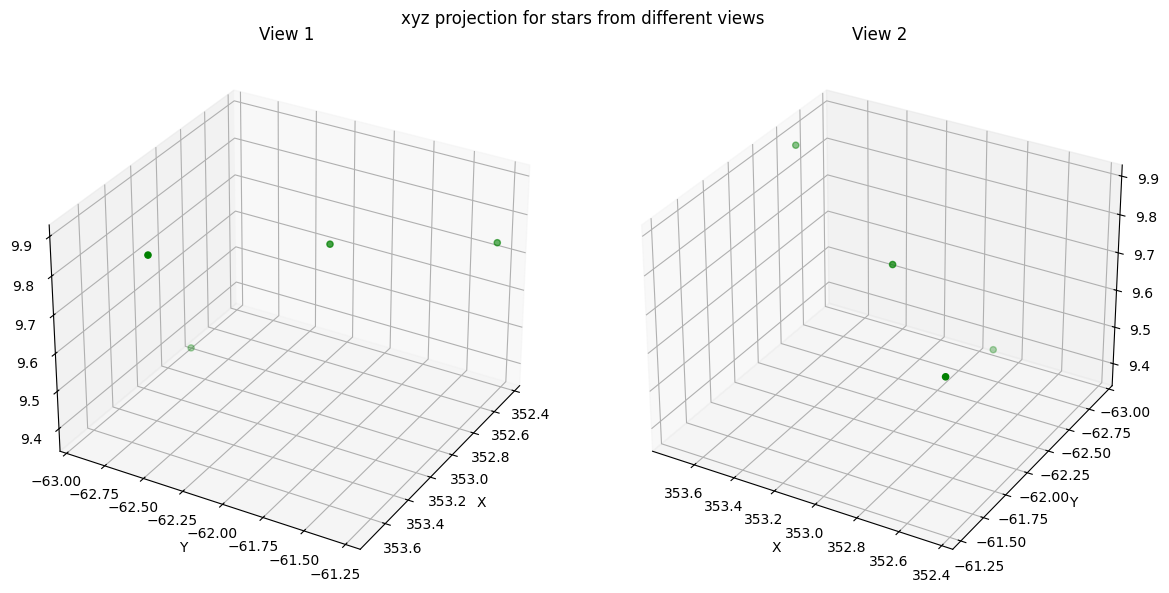

In [ ]:
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])  # set width ratio for each subplot
coords = torch.tensor(a)
# First subplot with one viewing angle
ax1 = fig.add_subplot(gs[0], projection='3d')
ax1.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c='green')
ax1.view_init(30, 30)  # Set elevation and azimuth
ax1.set_title('View 1')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Second subplot with another viewing angle
ax2 = fig.add_subplot(gs[1], projection='3d')
ax2.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c='green')
ax2.view_init(30, 120)  # Different elevation and azimuth
ax2.set_title('View 2')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.suptitle('xyz projection for stars from different views')
plt.tight_layout()
plt.show()

In [ ]:
df = pl.DataFrame({"foo": [1, 2, 3], "bar": [-1, 5, 8]})